# Prerequisites

In [1]:
# Import Libraries
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import layers
from keras.applications import DenseNet121, DenseNet169
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,classification_report, roc_auc_score,confusion_matrix

In [2]:
# Mounting G Drive for Data set Import
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Handling & EDA

In [3]:
## Reading Data
df = pd.read_excel("/content/drive/MyDrive/diabetic retinopathy_V03/Annotations of the classifications.xlsx")
df.head()

Image Format       Status
0      1    jpg  No DR signs
1      2    jpg  No DR signs
2      3    jpg  No DR signs
3      4    jpg  No DR signs
4      5    jpg  No DR signs

In [4]:
## Data Distribution
## imbalance classification
status_counts = df["Status"].value_counts()
status_counts

No DR signs             711
Severe NPDR             210
Advanced PDR            145
Very Severe NPDR        139
PDR                     116
Moderate NPDR           110
Mild (or early) NPDR      6
Name: Status, dtype: int64

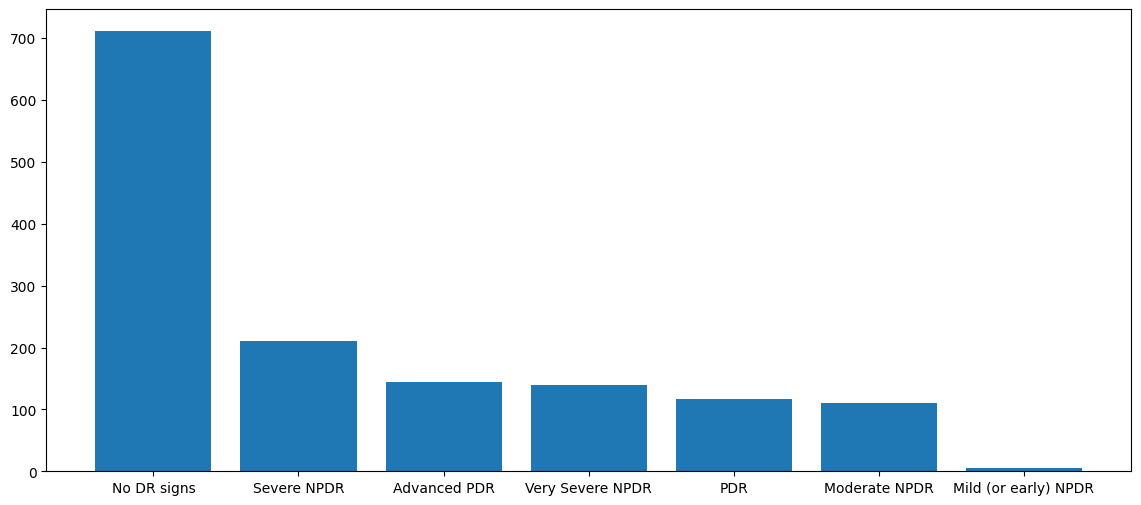

In [5]:
## Plot  a Bar Graph which gives each class count
## unbalanced data

plt.figure(figsize=(14,6))
plt.bar(status_counts.index, status_counts.values)

plt.show()

# Sample Images Image Processing Techniques


In [6]:
## Specifying a Path for Image Reading
files = os.listdir('/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/')

In [7]:
img_list = []

for i in files[0:20]:
    image = cv2.imread('/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/' + i)
    image = cv2.resize(src=image, dsize=(224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_list.append(image)

len(img_list)

20

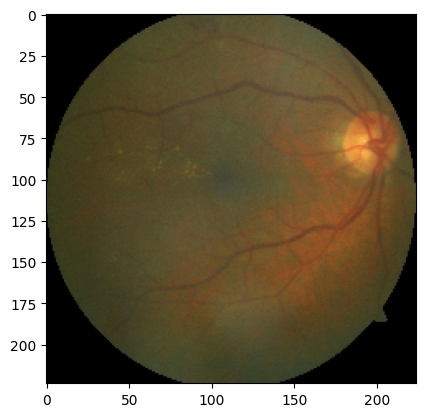

In [8]:
## Visualizing an Image

plt.imshow(img_list[6]);

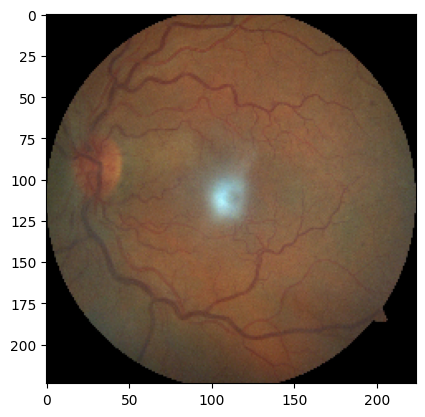

In [9]:
## Viz of Another Image
plt.imshow(img_list[4]);

In [10]:
img_list[4].shape

(224, 224, 3)

## Morphological Operations (Image Procesing Techniques to High Light Veins in Fundus Image)



1- THRESHOLD
 * Threshold works with GRAY Images

2- GAUSSIAN BLUR

3- FIND CONTOURS
 * cv2.RETR_EXTERNAL retrieves only the extreme outer contours of image

4- GET COORDINATES

5- CROP IMAGES

6- RESIZE IMAGES
 * When the images are cropped, their sizes are changed. Therefore we need to resize them again


(224, 224)

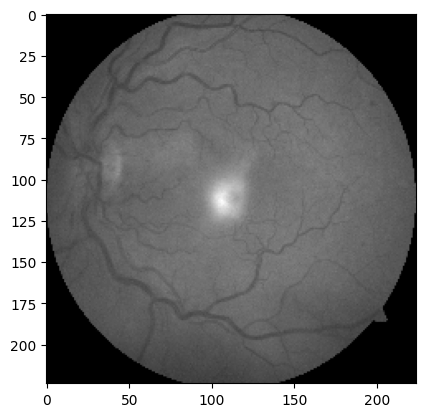

In [11]:

## Converting to Gray Image for Threshold

img = cv2.cvtColor(img_list[4].copy(), cv2.COLOR_RGB2GRAY)
plt.imshow(img, cmap='gray');
img.shape

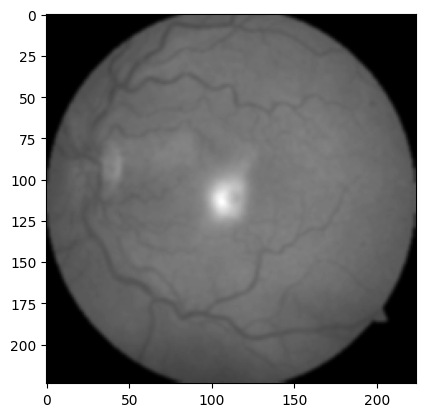

In [12]:
## Gaussian Blur (To build a robust Model)

blur = cv2.GaussianBlur(src=img, ksize=(5,5), sigmaX=0)
plt.imshow(blur, cmap='gray');

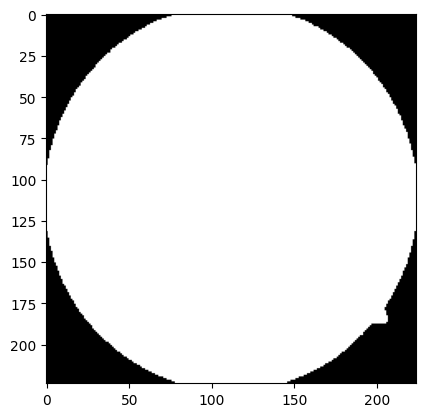

In [13]:
## Applying Threshold
thres = cv2.threshold(blur,10 ,255, cv2.THRESH_BINARY)[1]
plt.imshow(thres, cmap='gray');

In [14]:
## Finding Countours (Edge of an Image , Veins, Borders)
contour = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]

contour

array([[[ 77,   0]],

       [[ 75,   2]],

       [[ 73,   2]],

       [[ 72,   3]],

       [[ 70,   3]],

       [[ 69,   4]],

       [[ 67,   4]],

       [[ 66,   5]],

       [[ 65,   5]],

       [[ 64,   6]],

       [[ 63,   6]],

       [[ 62,   7]],

       [[ 61,   7]],

       [[ 59,   9]],

       [[ 58,   9]],

       [[ 57,  10]],

       [[ 56,  10]],

       [[ 55,  11]],

       [[ 54,  11]],

       [[ 52,  13]],

       [[ 51,  13]],

       [[ 48,  16]],

       [[ 47,  16]],

       [[ 45,  18]],

       [[ 44,  18]],

       [[ 41,  21]],

       [[ 40,  21]],

       [[ 39,  22]],

       [[ 39,  23]],

       [[ 38,  24]],

       [[ 37,  24]],

       [[ 30,  31]],

       [[ 30,  32]],

       [[ 24,  38]],

       [[ 24,  39]],

       [[ 21,  42]],

       [[ 21,  43]],

       [[ 18,  46]],

       [[ 18,  47]],

       [[ 17,  48]],

       [[ 17,  49]],

       [[ 15,  51]],

       [[ 15,  52]],

       [[ 14,  53]],

       [[ 14,  54]],

       [[ 

In [15]:
contour.shape

(281, 1, 2)

In [16]:
contour = contour[:,0,:]
contour.shape

(281, 2)

In [17]:
contour[:,0].argmax() ,contour[:,0].argmin() # min index # max. index

(216, 71)

In [18]:
## Final Co-Ordinates of Image (Borders of Image)
left = tuple(contour[contour[:,0].argmin()])
right = tuple(contour[contour[:,0].argmax()])
top = tuple(contour[contour[:,1].argmin()])
bottom = tuple(contour[contour[:,1].argmax()])

print(f"left: {left}\nright: {right}\ntop: {top}\nbottom: {bottom}\n")

left: (0, 92)
right: (223, 131)
top: (77, 0)
bottom: (78, 223)



In [19]:
x1 = left[0]
y1 = top[1]
x2 = right[0]
y2 = bottom[1]

print(f"left[0]: {x1}\ntop[1]: {y1}\nright[0]: {x2}\nbottom[1]: {y2}\n")

left[0]: 0
top[1]: 0
right[0]: 223
bottom[1]: 223



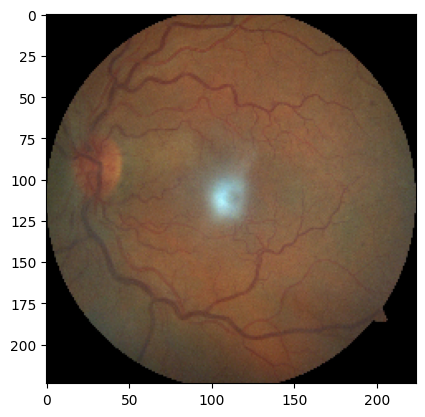

In [20]:
orj_img = img_list[4].copy()
plt.imshow(orj_img);

shape:  (223, 223, 3)


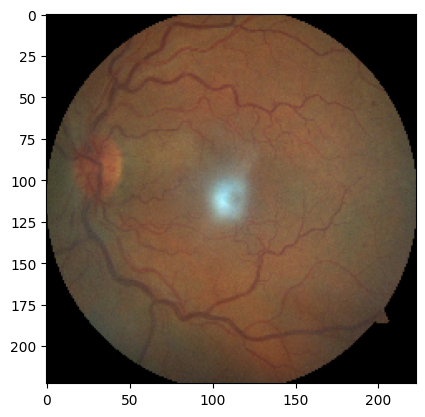

In [21]:
## Cropping Image

crop_img = orj_img[y1:y2, x1:x2]
plt.imshow(crop_img);
print("shape: ",crop_img.shape)

shape:  (400, 400, 3)


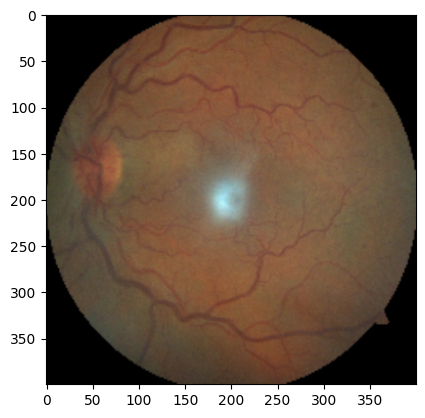

In [22]:
## Resizing Image

crop_img = cv2.resize(crop_img, (400,400))
plt.imshow(crop_img);
print("shape: ",crop_img.shape)

### Crop Images Again to Destroy Black Area

In [23]:
x = int(x2-x1)*4//100
y = int(y2-y1)*5//100

print(x,y)

8 11


shape:  (201, 207, 3)


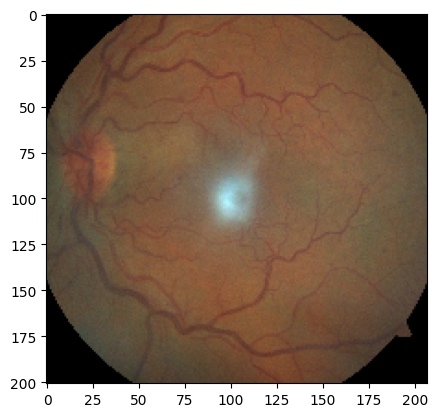

In [24]:
crop_img = orj_img[y1+y:y2-y, x1+x:x2-x]
plt.imshow(crop_img);
print("shape: ",crop_img.shape)

shape:  (400, 400, 3)


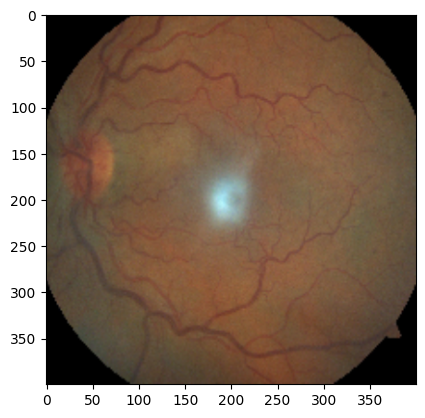

In [25]:
crop_img = cv2.resize(crop_img, (400,400))
plt.imshow(crop_img);
print("shape: ",crop_img.shape)


**Histogram Equalization**
* cv2.COLOR_RGB2LAB
  * LAB
  * L => Lightness
  * A => Green - Red
  * B => Blue - Yellow


In [26]:
lab = cv2.cvtColor(crop_img, cv2.COLOR_RGB2LAB)

lab.shape

(400, 400, 3)

In [27]:
l, a, b = cv2.split(lab)

shape:  (400, 400)


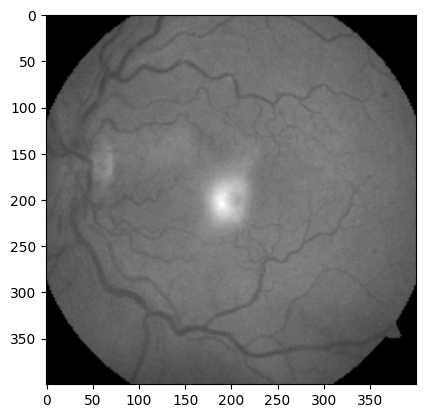

In [28]:
plt.imshow(l, cmap="gray");
print("shape: ", l.shape) # 2D

# Flatten for Histogram

In [29]:
flatten = l.flatten()

flatten.shape

(160000,)

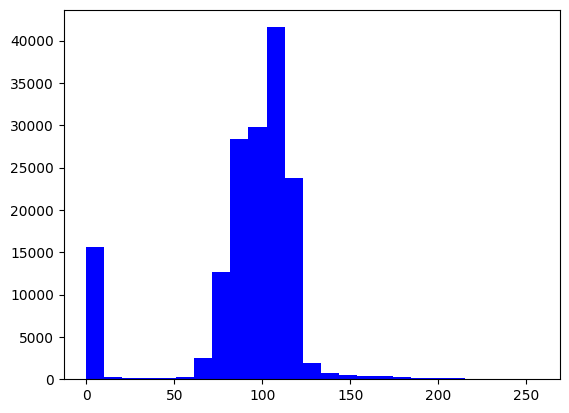

In [30]:
plt.hist(flatten, 25, [0,256], color="b")
plt.show()

# CLAHE - Contrast-Limited Adaptive Histogram Equalization

 * To applt CLAHE, we need to convert color from RGB to LAB => cv2.COLOR_RGB2LAB
 * Flatten for Histogram
 * **CLAHE**
 * Merge Operation
 * Convert color from LAB to RGB => cv2.COLOR_LAB2RGB
 * Median Blur for Avoid Noise

In [31]:
clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=((8,8)))

cl = clahe.apply(l)

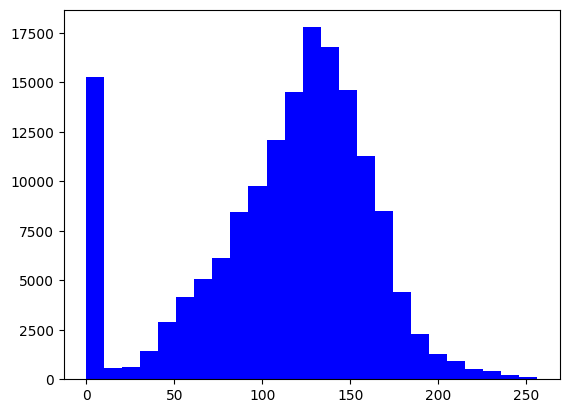

In [32]:
plt.hist(cl.flatten(), 25, [0,256], color="b")
plt.show()

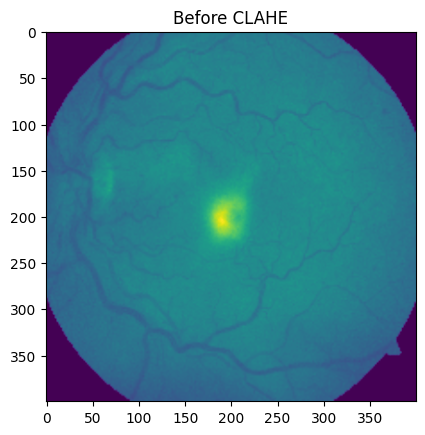

In [33]:
## LAB Color Map Image Green - Red to highlight Veins
plt.title("Before CLAHE")
plt.imshow(l);

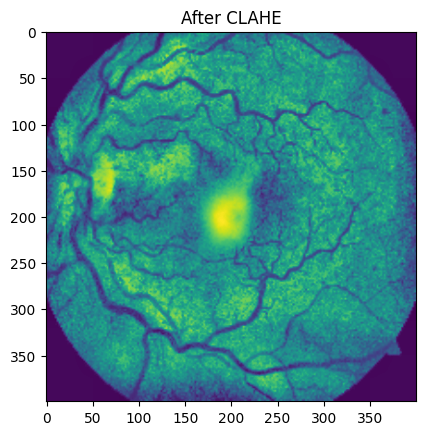

In [34]:
plt.title("After CLAHE")
plt.imshow(cl);

# Merge other channels

In [35]:
## Final Image After Merge all the changes (Clahe, Histogram, LAB )
merge = cv2.merge((cl, a, b))

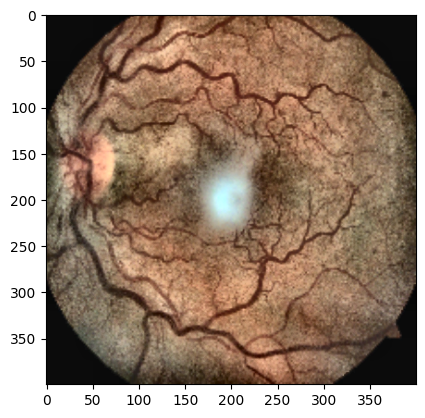

In [36]:
final_img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)

plt.imshow(final_img);

# Median Blur for Avoid Noise

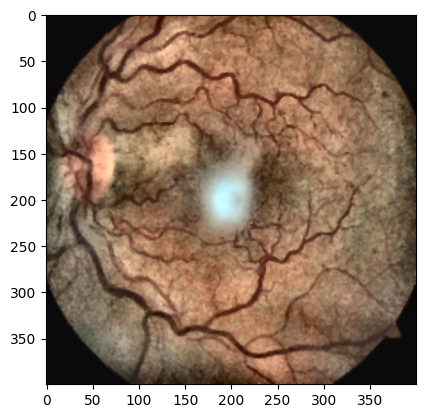

In [37]:
## Added Slight amount of blur to build a robust model
med_blur = cv2.medianBlur(final_img, ksize=3)

plt.imshow(med_blur);

# Mask for Bleeding Vein

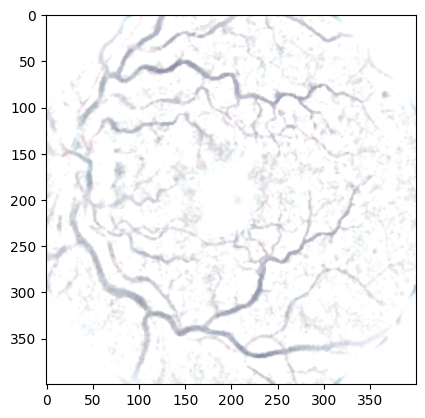

In [38]:
back_ground = cv2.medianBlur(final_img, ksize=35)

mask = cv2.addWeighted(med_blur, 1, back_ground, -1, 255)

plt.imshow(mask);

# Apply Mask to Image

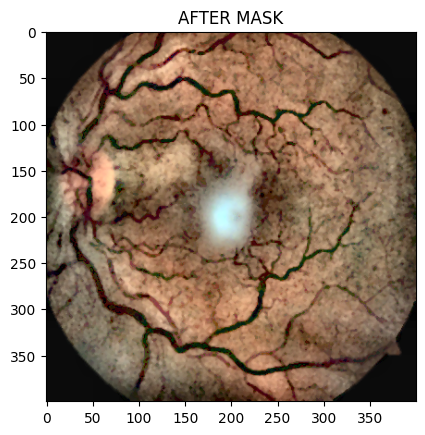

In [39]:
final_mask = cv2.bitwise_and(mask, med_blur)

plt.title("AFTER MASK")
plt.imshow(final_mask);

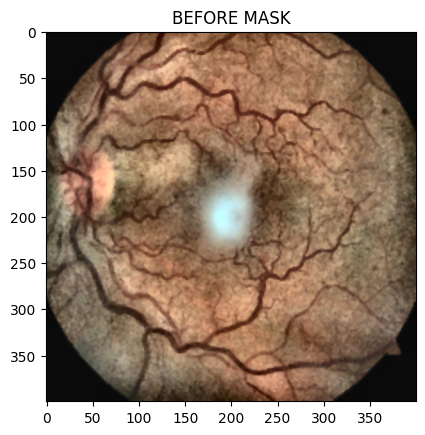

In [40]:
plt.title("BEFORE MASK")
plt.imshow(med_blur);

## Applying all Image Processing Technqiues to Data set for Training & Validation

In [41]:
from tqdm import tqdm_notebook as tqdm


def preprocessing(files,path):
    """
    This function returns images prepared for training
    """
    img_list = []
    for i in tqdm(files):
        image = cv2.imread(path + i)
        image = cv2.resize(image, (400, 400))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        copy = image.copy()
        copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(copy, (5, 5), 0)

        thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]

        # CONTOUR DETECTION
        contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = contour[0][0]
        contour = contour[:, 0, :]

        # GET COORDINATES
        x1 = tuple(contour[contour[:, 0].argmin()])[0]
        y1 = tuple(contour[contour[:, 1].argmin()])[1]
        x2 = tuple(contour[contour[:, 0].argmax()])[0]
        y2 = tuple(contour[contour[:, 1].argmax()])[1]

        #Crop Images Again to Destroy Black Area
        x = int(x2 - x1) * 4 // 50
        y = int(y2 - y1) * 5 // 50

        # THRES FOR CROPPED IMAGES
        copy2 = image.copy()
        if x2 - x1 > 100 and y2 - y1 > 100:
            copy2 = copy2[y1 + y: y2 - y, x1 + x: x2 - x]
            copy2 = cv2.resize(copy2, (240, 240))

        # LAB
        lab = cv2.cvtColor(copy2, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        # CLAHE - Contrast-Limited Adaptive Histogram Equalization
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=((8, 8)))
        cl = clahe.apply(l)

        # MERGING LAB
        merge = cv2.merge((cl, a, b))
        final_img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)
        med_blur = cv2.medianBlur(final_img, 3)
        back_gorund = cv2.medianBlur(final_img, 37)

        # MASK FOR BLEEDING VEIN
        mask = cv2.addWeighted(med_blur, 1, back_gorund, -1, 255)
        final = cv2.bitwise_and(mask, med_blur)
        img_list.append(final)

    return img_list

files1 = os.listdir('/content/drive/MyDrive/diabetic retinopathy_V03/1. No DR signs/')
path1='/content/drive/MyDrive/diabetic retinopathy_V03/1. No DR signs/'
files2 = os.listdir('/content/drive/MyDrive/diabetic retinopathy_V03/2. Mild (or early) NPDR/')
path2= '/content/drive/MyDrive/diabetic retinopathy_V03/2. Mild (or early) NPDR/'
files3 = os.listdir('/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/')
path3= '/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/'
files4 = os.listdir('/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/')
path4= '/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/'
files5 = os.listdir('/content/drive/MyDrive/diabetic retinopathy_V03/5. Very Severe NPDR/')
path5= '/content/drive/MyDrive/diabetic retinopathy_V03/5. Very Severe NPDR/'
files6 = os.listdir('/content/drive/MyDrive/diabetic retinopathy_V03/6. PDR/')
path6= '/content/drive/MyDrive/diabetic retinopathy_V03/6. PDR/'
files7 = os.listdir('/content/drive/MyDrive/diabetic retinopathy_V03/7. Advanced PDR/')
path7= '/content/drive/MyDrive/diabetic retinopathy_V03/7. Advanced PDR/'

img_list1 = preprocessing(files=files1,path=path1)
img_list2 = preprocessing(files=files2,path=path2)
img_list3 = preprocessing(files=files3,path=path3)
img_list4 = preprocessing(files=files4,path=path4)
img_list5 = preprocessing(files=files5,path=path5)
img_list6 = preprocessing(files=files6,path=path6)
img_list7 = preprocessing(files=files7,path=path7)



<ipython-input-41-f45e867a3941>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(files):


  0%|          | 0/731 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

In [42]:
## Mapping Class Names to Images (Categorical to Numeric )
temp=[]
for i in range(0,len(img_list1)):
  temp.append([i,1])
for i in range(0,len(img_list2)):
  temp.append([i,2])
for i in range(0,len(img_list3)):
  temp.append([i,3])
for i in range(0,len(img_list4)):
  temp.append([i,4])
for i in range(0,len(img_list5)):
  temp.append([i,5])
for i in range(0,len(img_list6)):
  temp.append([i,6])
for i in range(0,len(img_list7)):
  temp.append([i,7])

df=pd.DataFrame(temp,columns=['Image','status'])
df

Image  status
0         0       1
1         1       1
2         2       1
3         3       1
4         4       1
...     ...     ...
1452    140       7
1453    141       7
1454    142       7
1455    143       7
1456    144       7

[1457 rows x 2 columns]

In [43]:
## Final Dataset in a list Format
img_list1.extend(img_list2)
img_list1.extend(img_list3)
img_list1.extend(img_list4)
img_list1.extend(img_list5)
img_list1.extend(img_list6)
img_list1.extend(img_list7)

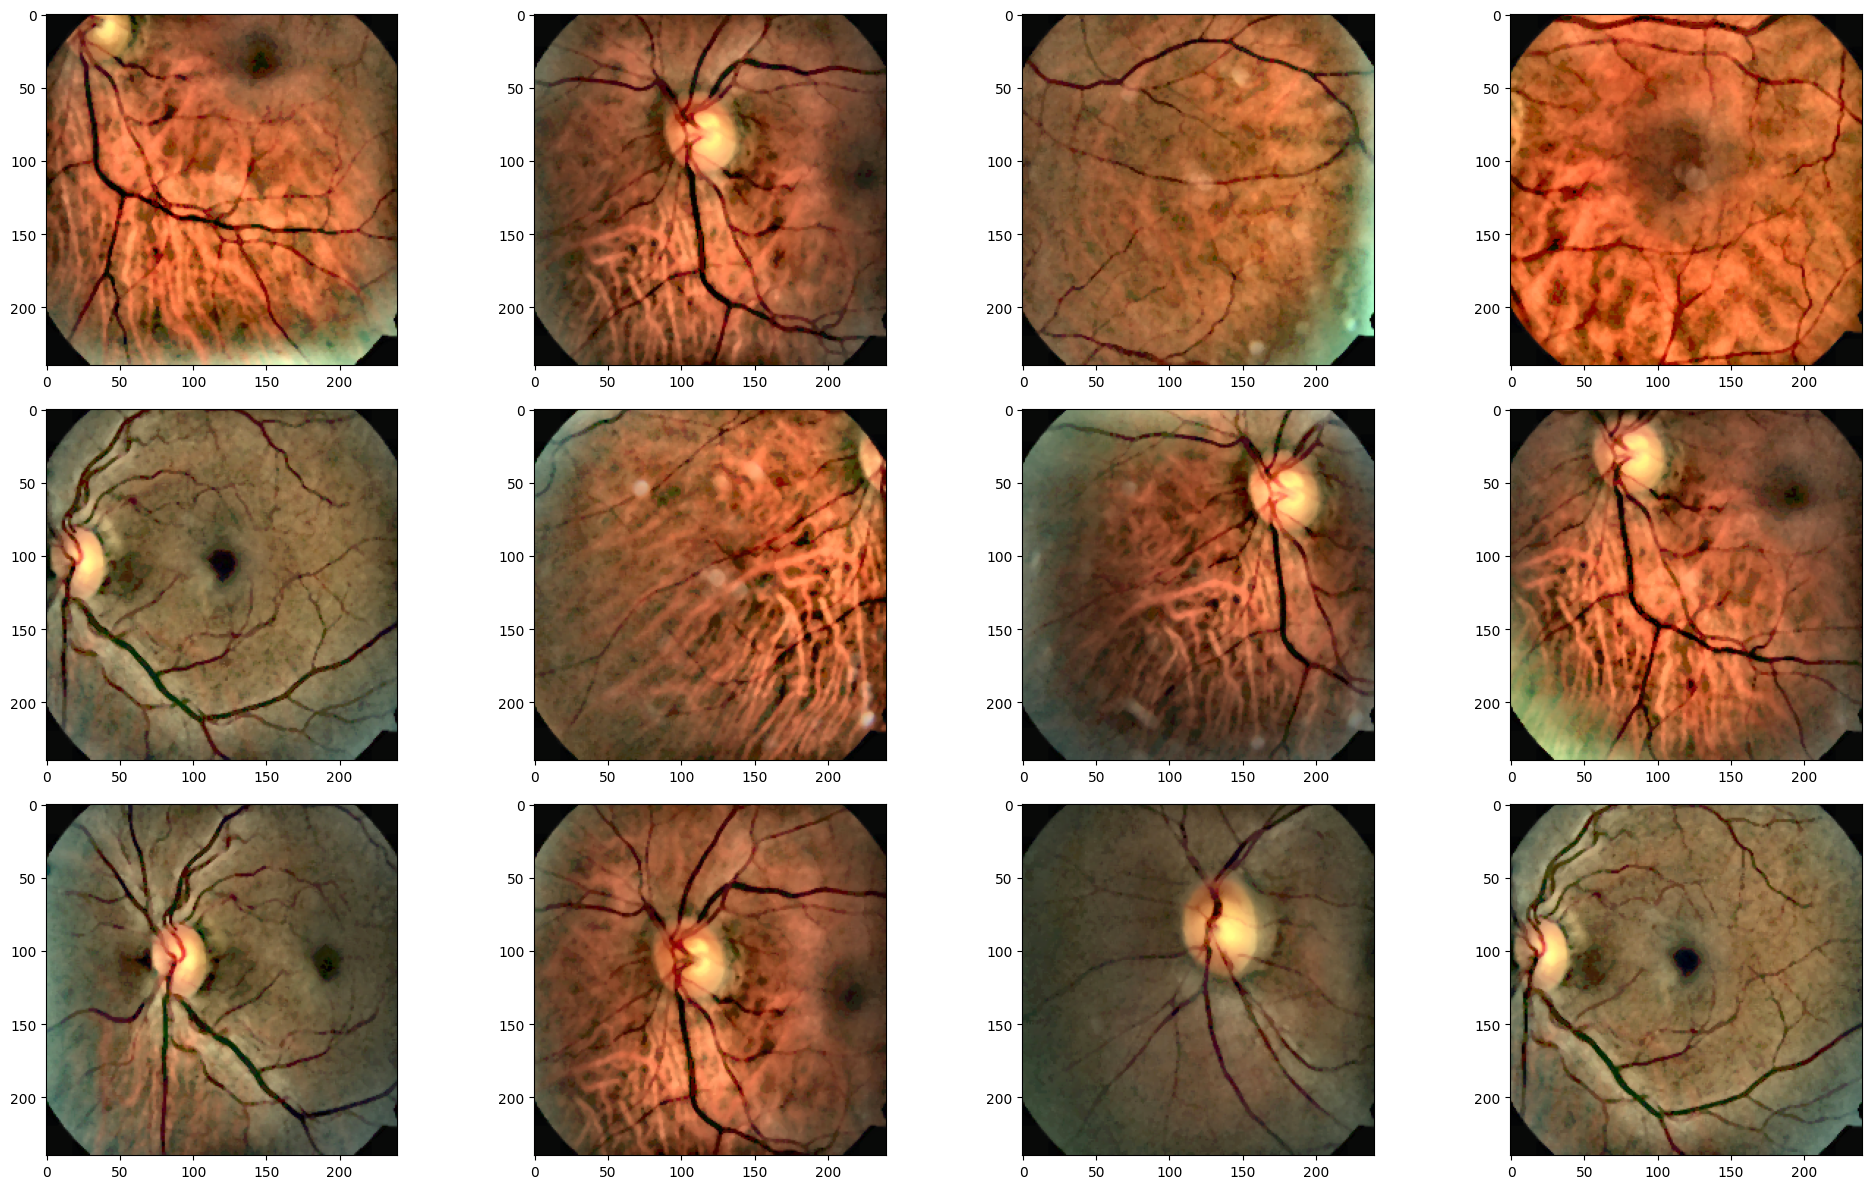

In [44]:
## Sample Images in the dataset (After Image Preprocessing)
fig = plt.figure(figsize=(20,12))

for i in range(12):
    img = img_list1[i]
    fig.add_subplot(3,4,i+1)
    plt.imshow(img)

plt.tight_layout()

# One Hot Encoding for DataFrame

In [45]:
df["status"]

0       1
1       1
2       1
3       1
4       1
       ..
1452    7
1453    7
1454    7
1455    7
1456    7
Name: status, Length: 1457, dtype: int64

In [46]:
## To represent target vairable as Multi Class Problem
y_train = pd.get_dummies(df["status"]).values
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

# Img to Array

In [47]:
x_train = np.array(img_list1)

x_train.shape

(1457, 240, 240, 3)

In [48]:
y_train.shape

(1457, 7)

# Train Test Split

In [49]:
X_train, X_val, y_train, y_val = train_test_split(x_train,  y_train,stratify=y_train, test_size=0.2)

factor=int(X_val.shape[0]*0.5)
rate=X_val.shape[0]-factor
X_val=X_val[:factor]
y_val=y_val[:factor]
X_val=np.append(X_val,X_train[:rate],axis=0)
y_val=np.append(y_val,y_train[:rate],axis=0)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X_train: (1165, 240, 240, 3)
X_val: (292, 240, 240, 3)
y_train: (1165, 7)
y_val: (292, 7)


# CUSTIOM CNN MODEL

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(240, 240, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# Flatten layer
model.add(Flatten())

# Dense (fully connected) layers
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to reduce overfitting
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 output classes, using softmax activation for multi-class classification

# Compile the model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics="binary_accuracy" )


# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 119, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 115, 115, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 57, 57, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 128)       7

## TRANING

In [51]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(X_train , y_train , epochs=20 , batch_size=128,validation_data=(X_val,y_val), verbose=1 , callbacks = callbacks)

Epoch 1/20
10/10 [==============================] - 28s 732ms/step - loss: 1.5858 - binary_accuracy: 0.8299 - val_loss: 0.4734 - val_binary_accuracy: 0.8611
Epoch 2/20
10/10 [==============================] - 3s 317ms/step - loss: 0.5175 - binary_accuracy: 0.8522 - val_loss: 0.3929 - val_binary_accuracy: 0.8659
Epoch 3/20
10/10 [==============================] - 3s 325ms/step - loss: 0.4524 - binary_accuracy: 0.8605 - val_loss: 0.3812 - val_binary_accuracy: 0.8801
Epoch 4/20
10/10 [==============================] - 3s 309ms/step - loss: 0.4226 - binary_accuracy: 0.8612 - val_loss: 0.3411 - val_binary_accuracy: 0.8625
Epoch 5/20
10/10 [==============================] - 3s 310ms/step - loss: 0.4131 - binary_accuracy: 0.8634 - val_loss: 0.3318 - val_binary_accuracy: 0.8684
Epoch 6/20
10/10 [==============================] - 3s 309ms/step - loss: 0.4004 - binary_accuracy: 0.8619 - val_loss: 0.3320 - val_binary_accuracy: 0.8885
Epoch 7/20
10/10 [==============================] - 3s 322ms/st

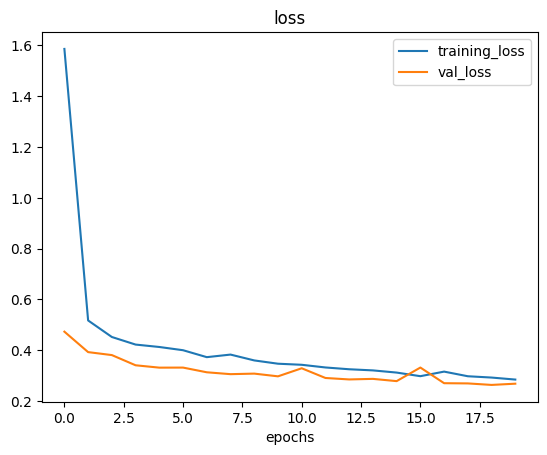

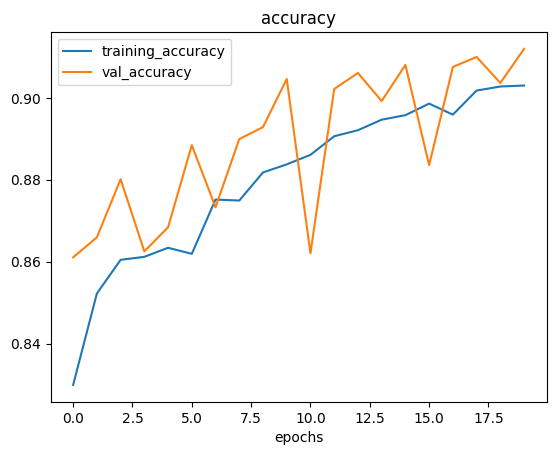

In [52]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

plot_curves(history)

In [53]:
pred = model.predict(X_val)
y_pred_val = np.argmax(pred,axis=1)
pred = np.argmax(pred,axis=1)

y_pred_train =model.predict(X_train)
y_pred_train =np.argmax(y_pred_train,axis=1)

37/37 [==============================] - 1s 24ms/step


In [54]:
diagnosis_classes = {
    1: 'No DR signs',
    2: 'Mild (or early) NPDR',
    3: 'Moderate NPDR',
    4: 'Severe NPDR',
    5: 'Very Severe NPDR',
    6: 'PDR',
    7: 'Advanced PDR'
}


df["type"] = df["status"].map(diagnosis_classes.get)

# METRICS

In [55]:
train_metric = round(accuracy_score(np.argmax(y_train,axis=1), y_pred_train))
val_metric = round(accuracy_score(np.argmax(y_val,axis=1), y_pred_val))
print("Training accuracy:",train_metric,"Validation accuracy:",val_metric)

train_metric = round(precision_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(precision_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training precision:",train_metric,"Validation precision:",val_metric)

train_metric = round(recall_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(recall_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training Recall:",train_metric,"Validation Recall:",val_metric)

train_metric = round(f1_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(f1_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training F1 score:",train_metric,"Validation F1-score:",val_metric)


print(classification_report(np.argmax(y_train,axis=1),y_pred_train,target_names=diagnosis_classes.values())) ## Training Classificaiton_report
print(classification_report(np.argmax(y_val,axis=1),y_pred_val,target_names=diagnosis_classes.values())) ## Validation Classificaiton_report

Training accuracy: 1 Validation accuracy: 1
Training precision: 0 Validation precision: 0
Training Recall: 0 Validation Recall: 0
Training F1 score: 0 Validation F1-score: 0
                      precision    recall  f1-score   support

         No DR signs       0.60      0.96      0.74       584
Mild (or early) NPDR       0.00      0.00      0.00         5
       Moderate NPDR       0.00      0.00      0.00        88
         Severe NPDR       0.38      0.54      0.45       168
    Very Severe NPDR       0.00      0.00      0.00       111
                 PDR       0.00      0.00      0.00        93
        Advanced PDR       0.00      0.00      0.00       116

            accuracy                           0.56      1165
           macro avg       0.14      0.21      0.17      1165
        weighted avg       0.36      0.56      0.44      1165

                      precision    recall  f1-score   support

         No DR signs       0.58      0.94      0.72       145
Mild (or early) 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

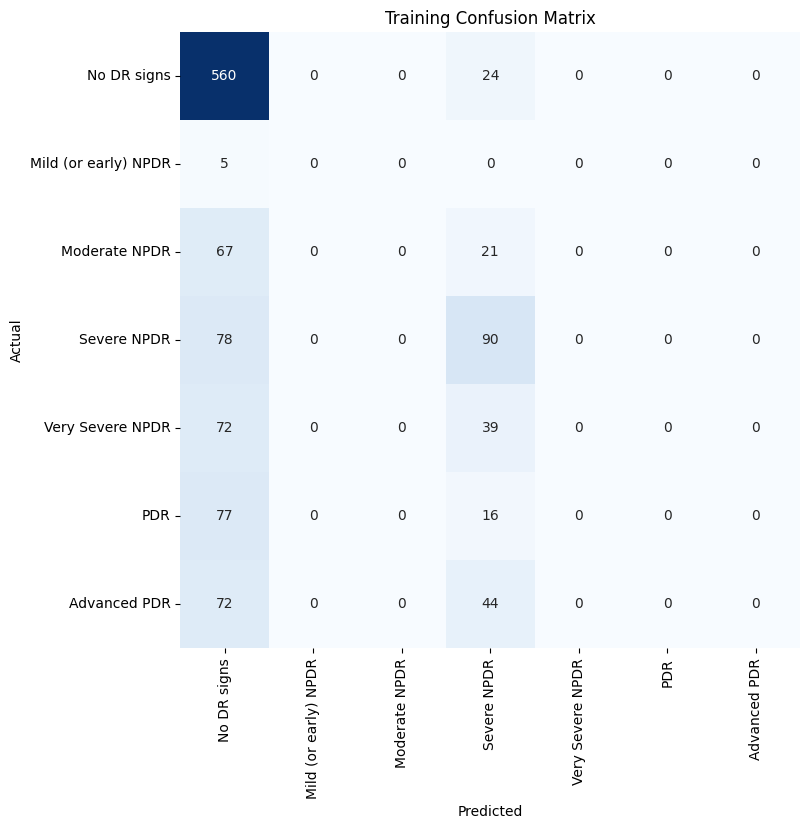

In [56]:
if len((diagnosis_classes.values()))<= 30:
        # create a confusion matrix
        cm = confusion_matrix(np.argmax(y_train,axis=1),y_pred_train)
        length=len(diagnosis_classes.values())
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, diagnosis_classes.values(), rotation= 90)
        plt.yticks(np.arange(length)+.5, diagnosis_classes.values(), rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Training Confusion Matrix")
        plt.show()

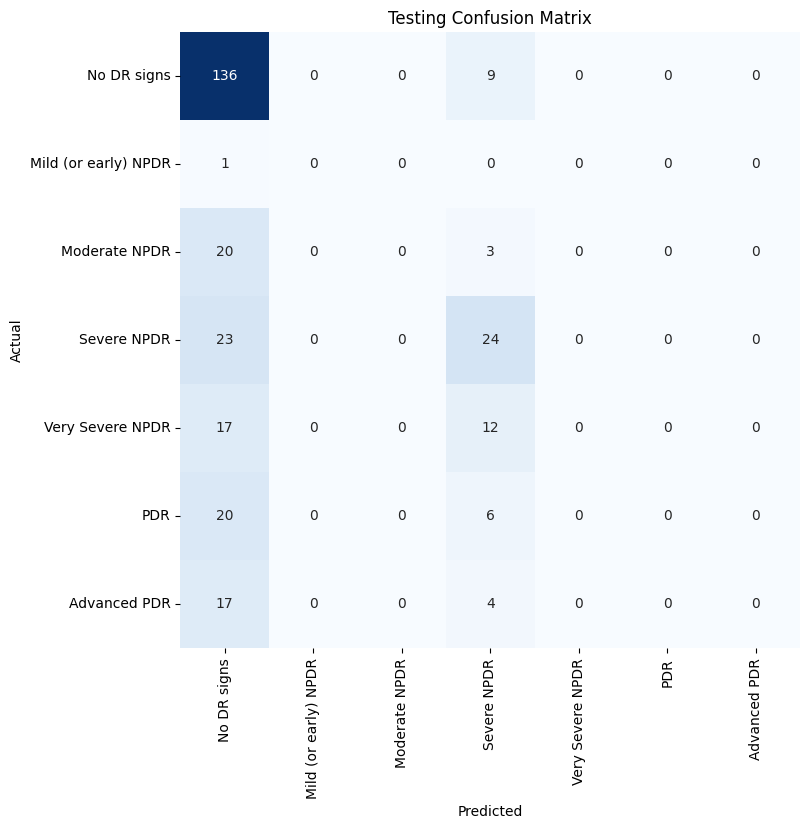

In [57]:
if len((diagnosis_classes.values()))<= 30:
      # create a confusion matrix
      cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred_val,labels=np.arange(0,len(diagnosis_classes),1))
      length=len(diagnosis_classes.values())
      if length<8:
          fig_width=8
          fig_height=8
      else:
          fig_width= int(length * .5)
          fig_height= int(length * .5)
      plt.figure(figsize=(fig_width, fig_height))
      sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
      plt.xticks(np.arange(length)+.5, diagnosis_classes.values(), rotation= 90)
      plt.yticks(np.arange(length)+.5, diagnosis_classes.values(), rotation=0)
      plt.xlabel("Predicted")
      plt.ylabel("Actual")
      plt.title("Testing Confusion Matrix")
      plt.show()

## PREDICTION FUNCTION

In [61]:
def predict_new(path):

    #predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"]
    img_list = []
    image = cv2.imread(path)
    image = cv2.resize(image, (400, 400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    copy = image.copy()
    copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(copy, (5, 5), 0)

    thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]

    # CONTOUR DETECTION
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = contour[0][0]
    contour = contour[:, 0, :]

    # GET COORDINATES
    x1 = tuple(contour[contour[:, 0].argmin()])[0]
    y1 = tuple(contour[contour[:, 1].argmin()])[1]
    x2 = tuple(contour[contour[:, 0].argmax()])[0]
    y2 = tuple(contour[contour[:, 1].argmax()])[1]

    #Crop Images Again to Destroy Black Area
    x = int(x2 - x1) * 4 // 50
    y = int(y2 - y1) * 5 // 50

    # THRES FOR CROPPED IMAGES
    copy2 = image.copy()
    if x2 - x1 > 100 and y2 - y1 > 100:
        copy2 = copy2[y1 + y: y2 - y, x1 + x: x2 - x]
        copy2 = cv2.resize(copy2, (240, 240))

    # LAB
    lab = cv2.cvtColor(copy2, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # CLAHE - Contrast-Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=((8, 8)))
    cl = clahe.apply(l)

    # MERGING LAB
    merge = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)
    med_blur = cv2.medianBlur(final_img, 3)
    back_gorund = cv2.medianBlur(final_img, 37)

    # MASK FOR BLEEDING VEIN
    mask = cv2.addWeighted(med_blur, 1, back_gorund, -1, 255)
    final = cv2.bitwise_and(mask, med_blur)
    img_list.append(final)
    ###############
    predict=model.predict(np.array(img_list))
    print(predict)
    pred=np.argmax(predict,axis=1)
    #pred=int(pred-1)
    print(pred)

    print(f"Predicted: {diagnosis_classes[int(pred)+1]}")

## SAMPLE PREDICTIONS

In [115]:
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1002.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1003.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1004.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1005.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1006.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1007.jpg")

1/1 [==============================] - 0s 33ms/step
[[2.5898011e-02 1.7049179e-07 2.6321234e-03 9.8272401e-01 2.6126439e-03
  1.2718741e-04 2.0289149e-06]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 32ms/step
[[5.11306629e-04 6.61698962e-08 1.00748835e-03 1.12273969e-01
  1.00143686e-01 6.14335537e-02 2.51700782e-04]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 30ms/step
[[2.8302274e-03 7.4411355e-10 7.8495094e-07 9.9950051e-01 1.6988552e-04
  2.6558433e-05 4.2053789e-04]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 33ms/step
[[9.44167899e-04 5.34008322e-08 3.31866630e-07 9.99272287e-01
  1.83356446e-04 2.54530081e-04 1.12817325e-02]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 32ms/step
[[1.0127964e-03 1.8911801e-06 1.3977049e-06 9.9875665e-01 4.1414471e-05
  1.2007681e-04 2.8017206e-02]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 32ms/step
[[7.0424087e-04 1.3

In [116]:
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/718.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/719.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/720.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/721.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/722.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/723.jpg")

1/1 [==============================] - 0s 31ms/step
[[9.0811744e-05 6.3902122e-10 9.9755943e-01 3.9289366e-06 1.9331954e-02
  1.5869828e-05 2.2253560e-12]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 30ms/step
[[3.9542916e-05 1.4666157e-11 9.9484938e-01 5.3196063e-06 2.6948215e-02
  2.3461728e-06 6.9324156e-12]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 30ms/step
[[3.0547846e-05 6.1209544e-11 9.9880147e-01 1.0110502e-02 6.8750731e-03
  3.5811030e-05 2.0323349e-10]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 31ms/step
[[2.7565000e-06 2.9152344e-11 9.9793637e-01 3.6080563e-04 2.5247646e-02
  9.5212527e-06 2.8590054e-12]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 32ms/step
[[2.0575822e-06 1.1291960e-11 9.9951184e-01 5.3626409e-04 3.6080062e-02
  1.4659962e-05 5.3523392e-12]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 33ms/step
[[6.92001850e-05 1.5292

# VGG-19

In [64]:
from keras.applications import VGG19
VGG19 = VGG19(include_top=False, input_shape= (240,240,3))

VGG19.trainable=False

model = Sequential()
model.add(VGG19)

model.add(Flatten())
model.add(Dense(128 , activation="relu"))
model.add(Dense(64 , activation="relu"))
model.add(Dense(32 , activation="relu"))
model.add(Dense(7 , activation="sigmoid"))

model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics="binary_accuracy" )
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               3211392   
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 7)                 231       
                                                       

## TRANING

In [65]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(X_train , y_train , epochs=20 , batch_size=128,validation_data=(X_val,y_val), verbose=1 , callbacks = callbacks)

Epoch 1/20
10/10 [==============================] - 49s 2s/step - loss: 2.2152 - binary_accuracy: 0.7779 - val_loss: 1.6306 - val_binary_accuracy: 0.8992
Epoch 2/20
10/10 [==============================] - 9s 938ms/step - loss: 0.9381 - binary_accuracy: 0.9025 - val_loss: 0.5195 - val_binary_accuracy: 0.8831
Epoch 3/20
10/10 [==============================] - 9s 941ms/step - loss: 0.3534 - binary_accuracy: 0.8953 - val_loss: 0.2691 - val_binary_accuracy: 0.9149
Epoch 4/20
10/10 [==============================] - 8s 867ms/step - loss: 0.1742 - binary_accuracy: 0.9400 - val_loss: 0.1925 - val_binary_accuracy: 0.9320
Epoch 5/20
10/10 [==============================] - 9s 938ms/step - loss: 0.1114 - binary_accuracy: 0.9594 - val_loss: 0.1689 - val_binary_accuracy: 0.9462
Epoch 6/20
10/10 [==============================] - 8s 851ms/step - loss: 0.0751 - binary_accuracy: 0.9722 - val_loss: 0.1534 - val_binary_accuracy: 0.9569
Epoch 7/20
10/10 [==============================] - 9s 958ms/step 

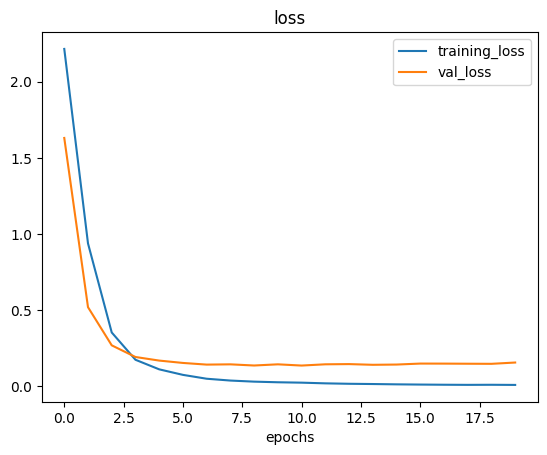

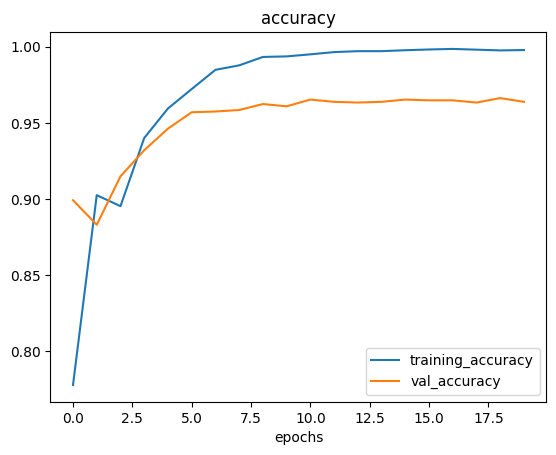

In [66]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

plot_curves(history)

In [67]:
pred = model.predict(X_val)
y_pred_val = np.argmax(pred,axis=1)
pred = np.argmax(pred,axis=1)

y_pred_train =model.predict(X_train)
y_pred_train =np.argmax(y_pred_train,axis=1)

37/37 [==============================] - 7s 180ms/step


In [68]:
df["status"].value_counts()

1    731
4    210
7    145
5    139
6    116
3    110
2      6
Name: status, dtype: int64

In [69]:
diagnosis_classes = {
    1: 'No DR signs',
    2: 'Mild (or early) NPDR',
    3: 'Moderate NPDR',
    4: 'Severe NPDR',
    5: 'Very Severe NPDR',
    6: 'PDR',
    7: 'Advanced PDR'
}

df["type"] = df["status"].map(diagnosis_classes.get)

## METRICS

In [70]:
train_metric = round(accuracy_score(np.argmax(y_train,axis=1), y_pred_train))
val_metric = round(accuracy_score(np.argmax(y_val,axis=1), y_pred_val))
print("Training accuracy:",train_metric,"Validation accuracy:",val_metric)

train_metric = round(precision_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(precision_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training precision:",train_metric,"Validation precision:",val_metric)

train_metric = round(recall_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(recall_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training Recall:",train_metric,"Validation Recall:",val_metric)

train_metric = round(f1_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(f1_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training F1 score:",train_metric,"Validation F1-score:",val_metric)


print(classification_report(np.argmax(y_train,axis=1),y_pred_train,target_names=diagnosis_classes.values())) ## Training Classificaiton_report
print(classification_report(np.argmax(y_val,axis=1),y_pred_val,target_names=diagnosis_classes.values())) ## Validation Classificaiton_report

Training accuracy: 1 Validation accuracy: 1
Training precision: 1 Validation precision: 1
Training Recall: 1 Validation Recall: 1
Training F1 score: 1 Validation F1-score: 1
                      precision    recall  f1-score   support

         No DR signs       1.00      1.00      1.00       584
Mild (or early) NPDR       1.00      1.00      1.00         5
       Moderate NPDR       1.00      1.00      1.00        88
         Severe NPDR       1.00      0.99      0.99       168
    Very Severe NPDR       1.00      1.00      1.00       111
                 PDR       0.96      1.00      0.98        93
        Advanced PDR       0.99      0.99      0.99       116

            accuracy                           1.00      1165
           macro avg       0.99      1.00      0.99      1165
        weighted avg       1.00      1.00      1.00      1165

                      precision    recall  f1-score   support

         No DR signs       0.95      0.98      0.97       145
Mild (or early) 

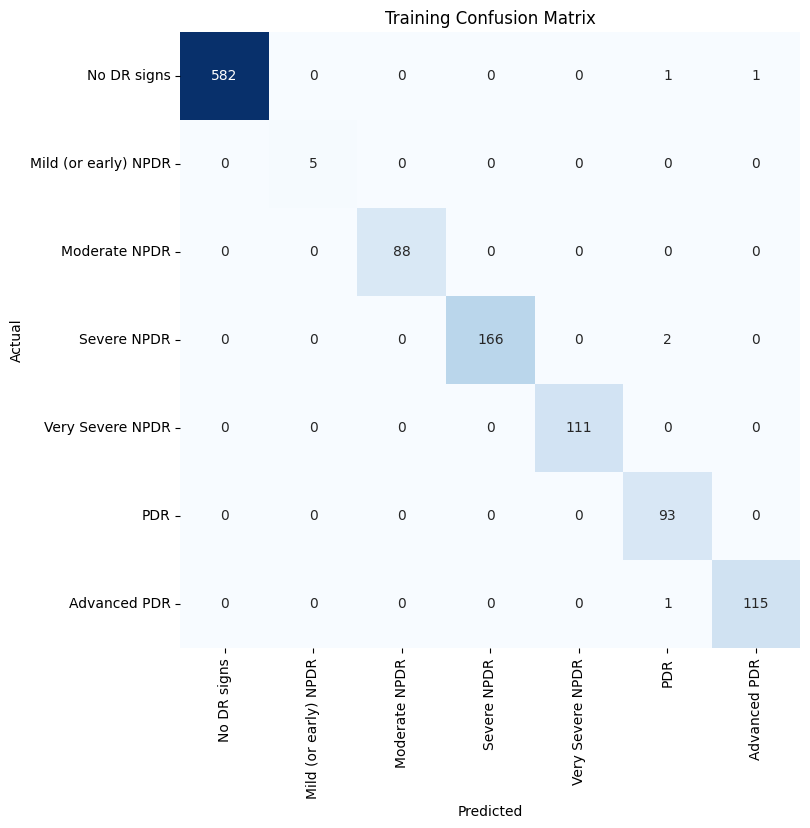

In [71]:
if len((diagnosis_classes.values()))<= 30:
        # create a confusion matrix
        cm = confusion_matrix(np.argmax(y_train,axis=1),y_pred_train)
        length=len(diagnosis_classes.values())
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, diagnosis_classes.values(), rotation= 90)
        plt.yticks(np.arange(length)+.5, diagnosis_classes.values(), rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Training Confusion Matrix")
        plt.show()

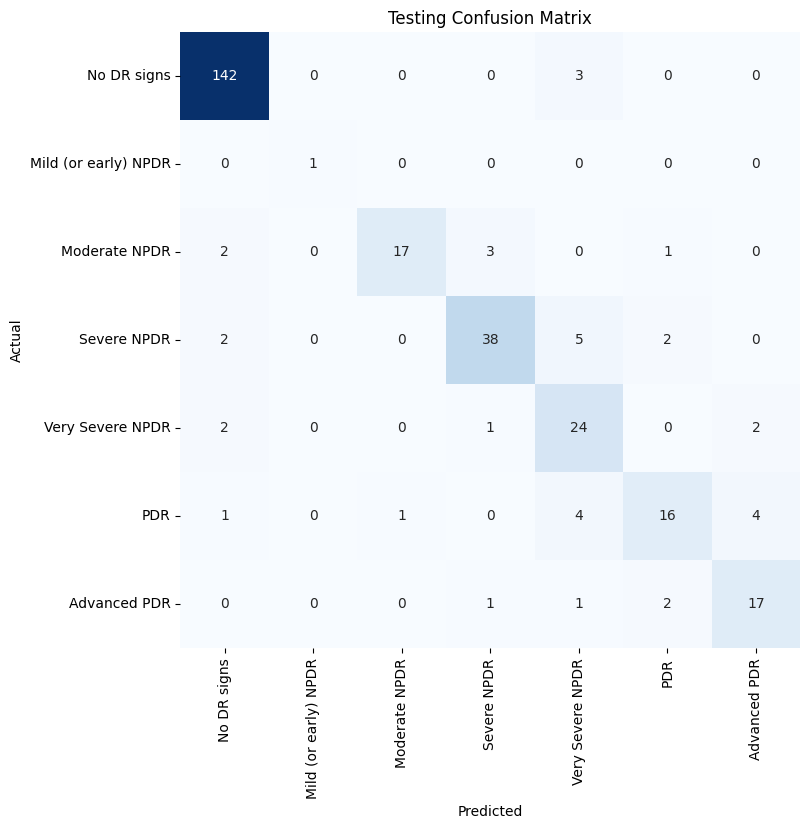

In [72]:
if len((diagnosis_classes.values()))<= 30:
      # create a confusion matrix
      cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred_val,labels=np.arange(0,len(diagnosis_classes),1))
      length=len(diagnosis_classes.values())
      if length<8:
          fig_width=8
          fig_height=8
      else:
          fig_width= int(length * .5)
          fig_height= int(length * .5)
      plt.figure(figsize=(fig_width, fig_height))
      sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
      plt.xticks(np.arange(length)+.5, diagnosis_classes.values(), rotation= 90)
      plt.yticks(np.arange(length)+.5, diagnosis_classes.values(), rotation=0)
      plt.xlabel("Predicted")
      plt.ylabel("Actual")
      plt.title("Testing Confusion Matrix")
      plt.show()

## PREDICTION FUNCTION

In [75]:
def predict_new(path):

    #predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"]
    img_list = []
    image = cv2.imread(path)
    image = cv2.resize(image, (400, 400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    copy = image.copy()
    copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(copy, (5, 5), 0)

    thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]

    # CONTOUR DETECTION
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = contour[0][0]
    contour = contour[:, 0, :]

    # GET COORDINATES
    x1 = tuple(contour[contour[:, 0].argmin()])[0]
    y1 = tuple(contour[contour[:, 1].argmin()])[1]
    x2 = tuple(contour[contour[:, 0].argmax()])[0]
    y2 = tuple(contour[contour[:, 1].argmax()])[1]

    #Crop Images Again to Destroy Black Area
    x = int(x2 - x1) * 4 // 50
    y = int(y2 - y1) * 5 // 50

    # THRES FOR CROPPED IMAGES
    copy2 = image.copy()
    if x2 - x1 > 100 and y2 - y1 > 100:
        copy2 = copy2[y1 + y: y2 - y, x1 + x: x2 - x]
        copy2 = cv2.resize(copy2, (240, 240))

    # LAB
    lab = cv2.cvtColor(copy2, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # CLAHE - Contrast-Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=((8, 8)))
    cl = clahe.apply(l)

    # MERGING LAB
    merge = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)
    med_blur = cv2.medianBlur(final_img, 3)
    back_gorund = cv2.medianBlur(final_img, 37)

    # MASK FOR BLEEDING VEIN
    mask = cv2.addWeighted(med_blur, 1, back_gorund, -1, 255)
    final = cv2.bitwise_and(mask, med_blur)
    img_list.append(final)
    ###############
    predict=model.predict(np.array(img_list))
    print(predict)
    pred=np.argmax(predict,axis=1)
    #pred=int(pred-1)
    print(pred)

    print(f"Predicted: {diagnosis_classes[int(pred)+1]}")

## SAMPLE PREDICTIONS

In [76]:
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1002.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1003.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1004.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1005.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1006.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1007.jpg")

1/1 [==============================] - 0s 18ms/step
[[5.4135389e-04 6.3817817e-05 3.0479025e-05 9.8038155e-01 7.3491270e-03
  8.7860208e-03 4.8497470e-05]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 20ms/step
[[1.5011715e-03 1.1941535e-05 4.3129156e-04 1.3572900e-01 1.0898898e-01
  1.2044585e-01 1.4468250e-04]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 18ms/step
[[2.5962058e-03 1.2633536e-04 5.8755500e-04 9.7999781e-01 9.3470821e-03
  1.5814029e-02 1.4962914e-03]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 18ms/step
[[6.0830871e-03 9.7326410e-05 5.9535028e-04 9.2562723e-01 1.8062091e-02
  5.6607988e-02 1.7053854e-02]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 18ms/step
[[1.4490742e-04 6.7096389e-06 3.5126274e-04 9.8860222e-01 1.0715446e-02
  9.0373280e-03 2.4391549e-02]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 17ms/step
[[2.88176187e-03 3.54753392e-05 4

In [77]:
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/718.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/719.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/720.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/721.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/722.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/723.jpg")

1/1 [==============================] - 0s 21ms/step
[[2.6240295e-05 2.4184475e-14 9.9891400e-01 1.2004763e-11 6.0094486e-04
  2.8848072e-04 1.9191517e-09]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 18ms/step
[[2.5910610e-06 1.5135924e-15 9.9809176e-01 5.1791726e-12 2.5291173e-04
  5.8267426e-05 2.1006590e-10]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 18ms/step
[[8.3291588e-06 1.7892213e-09 9.8617715e-01 9.0969252e-06 1.8534308e-03
  3.0005248e-03 6.9615184e-05]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 18ms/step
[[1.1026276e-05 2.4977565e-13 9.9973065e-01 2.3550314e-11 2.7949575e-03
  4.5118370e-04 7.8646695e-10]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 18ms/step
[[8.9153982e-06 1.9014480e-16 9.9901140e-01 3.5247196e-13 2.6181762e-04
  7.0946111e-04 4.0261188e-12]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 18ms/step
[[1.6437187e-04 6.14261

## DENSENET - 169

In [78]:
from keras.applications import  DenseNet169
DenseNet169 = DenseNet169(include_top=False, input_shape= (240,240,3))

DenseNet169.trainable=False

model = Sequential()
model.add(DenseNet169)

model.add(Flatten())
model.add(Dense(128 , activation="relu"))
model.add(Dense(64 , activation="relu"))
#model.add(Dropout(0.25))
model.add(Dense(64 , activation="relu"))
#model.add(Dropout(0.25))
model.add(Dense(7 , activation="sigmoid"))

model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics="binary_accuracy" )
model.summary()

51877672/51877672 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten_2 (Flatten)         (None, 81536)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               10436736  
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 7)                 455       
                                                       

## Training

In [79]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(X_train , y_train , epochs=20 , batch_size=128,validation_data=(X_val,y_val), verbose=1 , callbacks = callbacks)

Epoch 1/20
10/10 [==============================] - 44s 2s/step - loss: 2.2456 - binary_accuracy: 0.7908 - val_loss: 1.2234 - val_binary_accuracy: 0.8841
Epoch 2/20
10/10 [==============================] - 6s 593ms/step - loss: 0.9994 - binary_accuracy: 0.8844 - val_loss: 0.4733 - val_binary_accuracy: 0.8904
Epoch 3/20
10/10 [==============================] - 6s 604ms/step - loss: 0.3976 - binary_accuracy: 0.8817 - val_loss: 0.2788 - val_binary_accuracy: 0.9114
Epoch 4/20
10/10 [==============================] - 6s 563ms/step - loss: 0.2355 - binary_accuracy: 0.9208 - val_loss: 0.2249 - val_binary_accuracy: 0.9183
Epoch 5/20
10/10 [==============================] - 6s 568ms/step - loss: 0.1582 - binary_accuracy: 0.9397 - val_loss: 0.2067 - val_binary_accuracy: 0.9251
Epoch 6/20
10/10 [==============================] - 6s 569ms/step - loss: 0.1267 - binary_accuracy: 0.9485 - val_loss: 0.1923 - val_binary_accuracy: 0.9325
Epoch 7/20
10/10 [==============================] - 6s 561ms/step 

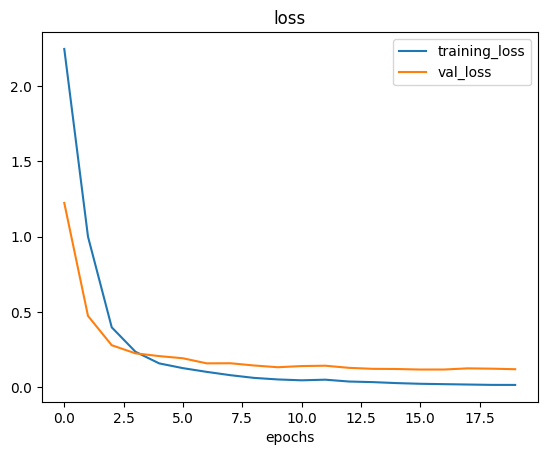

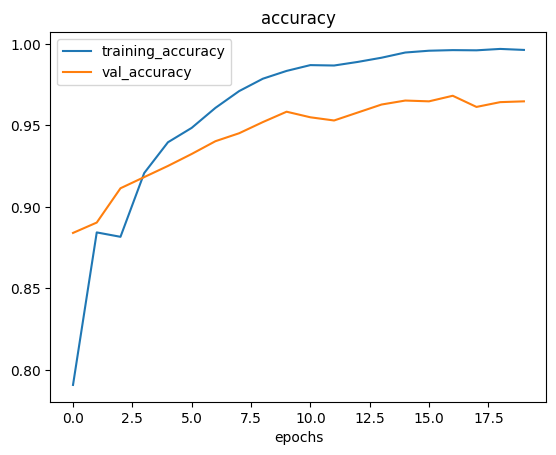

In [80]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

plot_curves(history)

In [81]:
pred = model.predict(X_val)
y_pred_val = np.argmax(pred,axis=1)
pred = np.argmax(pred,axis=1)

y_pred_train =model.predict(X_train)
y_pred_train =np.argmax(y_pred_train,axis=1)

37/37 [==============================] - 4s 120ms/step


In [82]:
df["status"].value_counts()

1    731
4    210
7    145
5    139
6    116
3    110
2      6
Name: status, dtype: int64

In [83]:
diagnosis_classes = {
    1: 'No DR signs',
    2: 'Mild (or early) NPDR',
    3: 'Moderate NPDR',
    4: 'Severe NPDR',
    5: 'Very Severe NPDR',
    6: 'PDR',
    7: 'Advanced PDR'
}


df["type"] = df["status"].map(diagnosis_classes.get)

## METRICS

In [84]:
train_metric = round(accuracy_score(np.argmax(y_train,axis=1), y_pred_train))
val_metric = round(accuracy_score(np.argmax(y_val,axis=1), y_pred_val))
print("Training accuracy:",train_metric,"Validation accuracy:",val_metric)

train_metric = round(precision_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(precision_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training precision:",train_metric,"Validation precision:",val_metric)

train_metric = round(recall_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(recall_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training Recall:",train_metric,"Validation Recall:",val_metric)

train_metric = round(f1_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(f1_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training F1 score:",train_metric,"Validation F1-score:",val_metric)


print(classification_report(np.argmax(y_train,axis=1),y_pred_train,target_names=diagnosis_classes.values())) ## Training Classificaiton_report
print(classification_report(np.argmax(y_val,axis=1),y_pred_val,target_names=diagnosis_classes.values())) ## Validation Classificaiton_report

Training accuracy: 1 Validation accuracy: 1
Training precision: 1 Validation precision: 1
Training Recall: 1 Validation Recall: 1
Training F1 score: 1 Validation F1-score: 1
                      precision    recall  f1-score   support

         No DR signs       1.00      1.00      1.00       584
Mild (or early) NPDR       1.00      1.00      1.00         5
       Moderate NPDR       1.00      1.00      1.00        88
         Severe NPDR       1.00      0.99      0.99       168
    Very Severe NPDR       1.00      1.00      1.00       111
                 PDR       0.97      0.99      0.98        93
        Advanced PDR       0.98      1.00      0.99       116

            accuracy                           1.00      1165
           macro avg       0.99      1.00      0.99      1165
        weighted avg       1.00      1.00      1.00      1165

                      precision    recall  f1-score   support

         No DR signs       0.95      0.97      0.96       145
Mild (or early) 

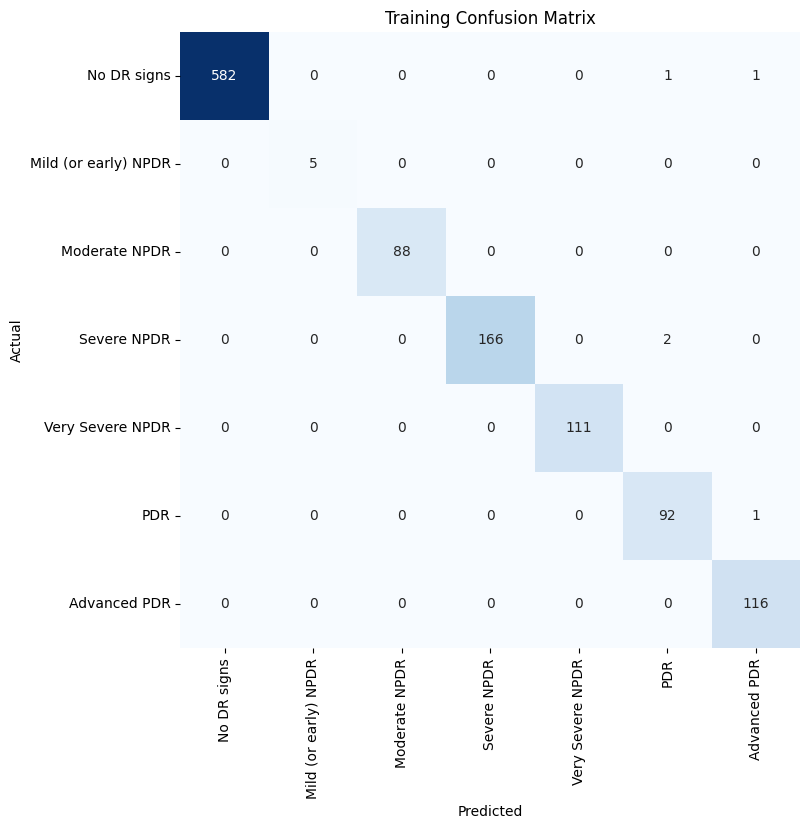

In [85]:
if len((diagnosis_classes.values()))<= 30:
        # create a confusion matrix
        cm = confusion_matrix(np.argmax(y_train,axis=1),y_pred_train)
        length=len(diagnosis_classes.values())
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, diagnosis_classes.values(), rotation= 90)
        plt.yticks(np.arange(length)+.5, diagnosis_classes.values(), rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Training Confusion Matrix")
        plt.show()

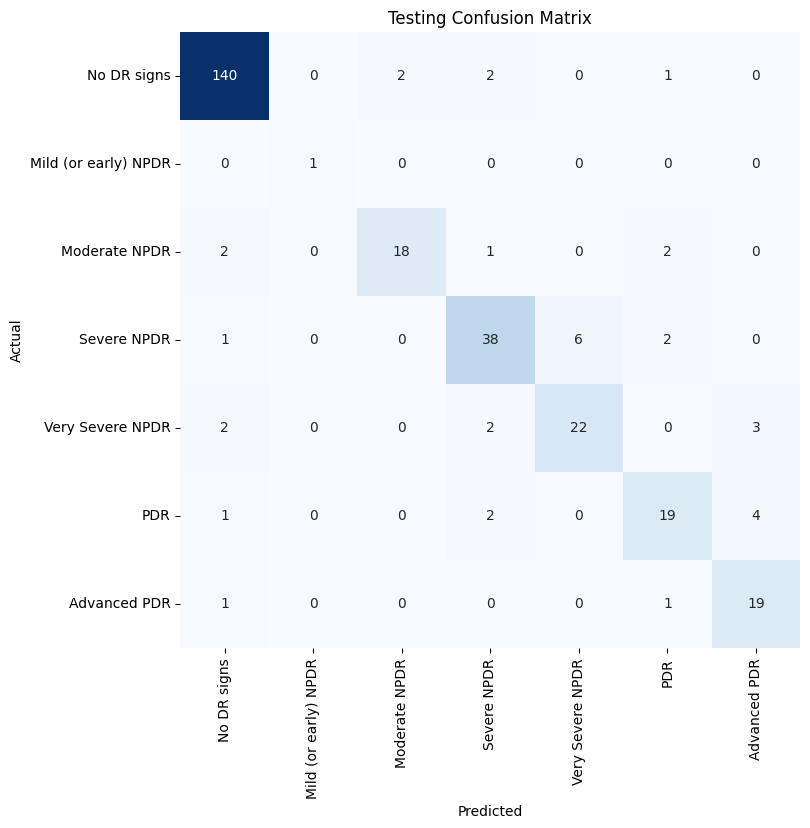

In [86]:
if len((diagnosis_classes.values()))<= 30:
      # create a confusion matrix
      cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred_val,labels=np.arange(0,len(diagnosis_classes),1))
      length=len(diagnosis_classes.values())
      if length<8:
          fig_width=8
          fig_height=8
      else:
          fig_width= int(length * .5)
          fig_height= int(length * .5)
      plt.figure(figsize=(fig_width, fig_height))
      sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
      plt.xticks(np.arange(length)+.5, diagnosis_classes.values(), rotation= 90)
      plt.yticks(np.arange(length)+.5, diagnosis_classes.values(), rotation=0)
      plt.xlabel("Predicted")
      plt.ylabel("Actual")
      plt.title("Testing Confusion Matrix")
      plt.show()

## PREDICTION FUNCTION

In [87]:
def predict_new(path):

    #predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"]
    img_list = []
    image = cv2.imread(path)
    image = cv2.resize(image, (400, 400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    copy = image.copy()
    copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(copy, (5, 5), 0)

    thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]

    # CONTOUR DETECTION
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = contour[0][0]
    contour = contour[:, 0, :]

    # GET COORDINATES
    x1 = tuple(contour[contour[:, 0].argmin()])[0]
    y1 = tuple(contour[contour[:, 1].argmin()])[1]
    x2 = tuple(contour[contour[:, 0].argmax()])[0]
    y2 = tuple(contour[contour[:, 1].argmax()])[1]

    #Crop Images Again to Destroy Black Area
    x = int(x2 - x1) * 4 // 50
    y = int(y2 - y1) * 5 // 50

    # THRES FOR CROPPED IMAGES
    copy2 = image.copy()
    if x2 - x1 > 100 and y2 - y1 > 100:
        copy2 = copy2[y1 + y: y2 - y, x1 + x: x2 - x]
        copy2 = cv2.resize(copy2, (240, 240))

    # LAB
    lab = cv2.cvtColor(copy2, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # CLAHE - Contrast-Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=((8, 8)))
    cl = clahe.apply(l)

    # MERGING LAB
    merge = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)
    med_blur = cv2.medianBlur(final_img, 3)
    back_gorund = cv2.medianBlur(final_img, 37)

    # MASK FOR BLEEDING VEIN
    mask = cv2.addWeighted(med_blur, 1, back_gorund, -1, 255)
    final = cv2.bitwise_and(mask, med_blur)
    img_list.append(final)
    ###############
    predict=model.predict(np.array(img_list))
    print(predict)
    pred=np.argmax(predict,axis=1)
    #pred=int(pred-1)
    print(pred)

    print(f"Predicted: {diagnosis_classes[int(pred)+1]}")

## SAMPLE PREDICTIONS

In [88]:
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1002.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1003.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1004.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1005.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1006.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1007.jpg")

1/1 [==============================] - 2s 2s/step
[[7.2669379e-02 2.3726025e-03 1.7189601e-02 8.8689971e-01 3.9941028e-02
  4.4649221e-02 5.2355765e-05]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 34ms/step
[[2.16036476e-02 3.76355398e-04 3.72472405e-03 5.69514871e-01
  1.18422575e-01 6.14207759e-02 2.57778738e-04]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 33ms/step
[[9.1789933e-03 1.5069668e-04 1.8856113e-05 9.4013685e-01 3.2464761e-02
  7.0047915e-02 1.1504238e-03]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 33ms/step
[[1.8863332e-02 7.4263843e-04 1.4354593e-04 9.1571754e-01 2.3529416e-02
  5.9977558e-02 2.0886003e-03]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 31ms/step
[[9.7647309e-04 8.6755732e-05 4.1424541e-05 9.0153325e-01 2.6968615e-02
  6.1483651e-02 5.1214444e-03]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 31ms/step
[[9.4180360e-02 4.8659490e-0

In [89]:
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/718.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/719.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/720.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/721.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/722.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/723.jpg")

1/1 [==============================] - 0s 31ms/step
[[1.0949394e-02 6.8750178e-06 9.9592650e-01 2.3386858e-05 7.5852703e-03
  7.0315582e-06 2.6676025e-07]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 31ms/step
[[1.29032675e-02 4.99078055e-07 9.98971224e-01 1.52295365e-06
  4.94337874e-04 1.31537865e-06 1.40297843e-07]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 33ms/step
[[1.4114071e-03 8.8419517e-07 9.9926895e-01 5.5368146e-05 1.2769486e-04
  1.5644158e-05 1.3386958e-05]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 32ms/step
[[1.6440948e-03 7.6271186e-07 9.9939334e-01 1.2298532e-04 3.0450716e-03
  3.1057192e-05 1.7715479e-06]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 32ms/step
[[1.7879955e-03 1.7257767e-06 9.9896169e-01 2.1908141e-04 3.3371816e-03
  2.0434363e-05 9.6567019e-06]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 33ms/step
[[1.31832871e-06

#DensNet-121

In [90]:
from keras.applications import DenseNet121, DenseNet169
Densenet121 = DenseNet121(include_top=False, input_shape= (240,240,3))

Densenet121.trainable=False

model = Sequential()
model.add(Densenet121)
model.add(Flatten())
model.add(Dense(128 , activation="relu"))
model.add(Dense(64 , activation="relu"))
model.add(Dense(32 , activation="relu"))
model.add(Dense(7 , activation="sigmoid"))

model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics="binary_accuracy" )
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_13 (Dense)            (None, 128)               6422656   
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 7)                 231       
                                                       

## Training

In [91]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(X_train , y_train , epochs=20 , batch_size=128,validation_data=(X_val,y_val), verbose=1 , callbacks = callbacks)

Epoch 1/20
10/10 [==============================] - 16s 789ms/step - loss: 1.7957 - binary_accuracy: 0.8052 - val_loss: 0.9612 - val_binary_accuracy: 0.8655
Epoch 2/20
10/10 [==============================] - 5s 474ms/step - loss: 0.7505 - binary_accuracy: 0.8866 - val_loss: 0.5461 - val_binary_accuracy: 0.9007
Epoch 3/20
10/10 [==============================] - 5s 514ms/step - loss: 0.4354 - binary_accuracy: 0.9085 - val_loss: 0.3456 - val_binary_accuracy: 0.9066
Epoch 4/20
10/10 [==============================] - 5s 475ms/step - loss: 0.2819 - binary_accuracy: 0.9185 - val_loss: 0.2759 - val_binary_accuracy: 0.9129
Epoch 5/20
10/10 [==============================] - 5s 482ms/step - loss: 0.2173 - binary_accuracy: 0.9188 - val_loss: 0.2210 - val_binary_accuracy: 0.9154
Epoch 6/20
10/10 [==============================] - 5s 477ms/step - loss: 0.1785 - binary_accuracy: 0.9328 - val_loss: 0.2095 - val_binary_accuracy: 0.9242
Epoch 7/20
10/10 [==============================] - 5s 528ms/st

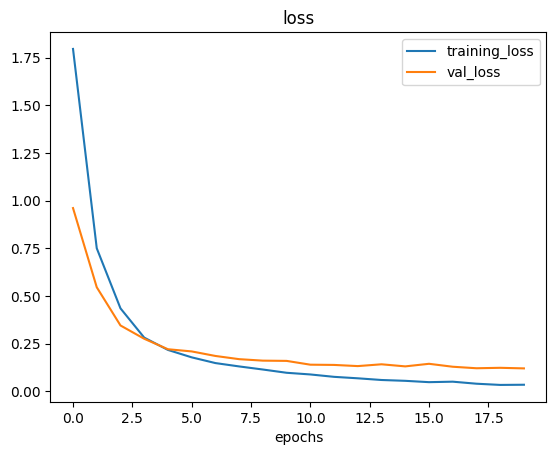

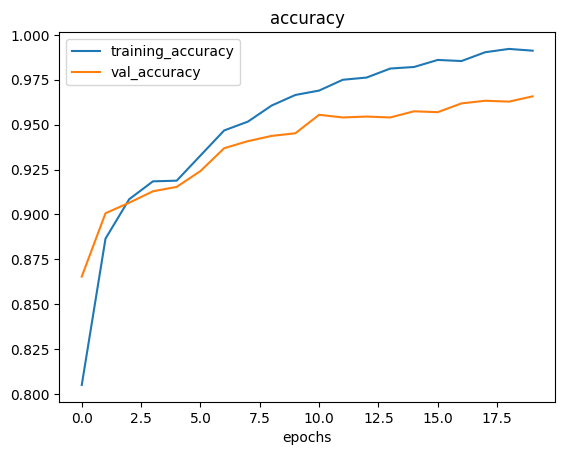

In [92]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

plot_curves(history)

In [93]:
pred = model.predict(X_val)
y_pred_val = np.argmax(pred,axis=1)
pred = np.argmax(pred,axis=1)

y_pred_train =model.predict(X_train)
y_pred_train =np.argmax(y_pred_train,axis=1)

37/37 [==============================] - 4s 97ms/step


In [94]:
df["status"].value_counts()

1    731
4    210
7    145
5    139
6    116
3    110
2      6
Name: status, dtype: int64

In [95]:
diagnosis_classes = {
    1: 'No DR signs',
    2: 'Mild (or early) NPDR',
    3: 'Moderate NPDR',
    4: 'Severe NPDR',
    5: 'Very Severe NPDR',
    6: 'PDR',
    7: 'Advanced PDR'
}



df["type"] = df["status"].map(diagnosis_classes.get)



## Metrics

In [96]:
train_metric = round(accuracy_score(np.argmax(y_train,axis=1), y_pred_train))
val_metric = round(accuracy_score(np.argmax(y_val,axis=1), y_pred_val))
print("Training accuracy:",train_metric,"Validation accuracy:",val_metric)

train_metric = round(precision_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(precision_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training precision:",train_metric,"Validation precision:",val_metric)

train_metric = round(recall_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(recall_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training Recall:",train_metric,"Validation Recall:",val_metric)

train_metric = round(f1_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = round(f1_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training F1 score:",train_metric,"Validation F1-score:",val_metric)


print(classification_report(np.argmax(y_train,axis=1),y_pred_train,target_names=diagnosis_classes.values())) ## Training Classificaiton_report
print(classification_report(np.argmax(y_val,axis=1),y_pred_val,target_names=diagnosis_classes.values())) ## Validation Classificaiton_report

Training accuracy: 1 Validation accuracy: 1
Training precision: 1 Validation precision: 1
Training Recall: 1 Validation Recall: 1
Training F1 score: 1 Validation F1-score: 1
                      precision    recall  f1-score   support

         No DR signs       1.00      1.00      1.00       584
Mild (or early) NPDR       1.00      1.00      1.00         5
       Moderate NPDR       1.00      0.93      0.96        88
         Severe NPDR       0.97      0.99      0.98       168
    Very Severe NPDR       0.93      1.00      0.97       111
                 PDR       0.98      0.88      0.93        93
        Advanced PDR       0.97      0.98      0.98       116

            accuracy                           0.98      1165
           macro avg       0.98      0.97      0.97      1165
        weighted avg       0.98      0.98      0.98      1165

                      precision    recall  f1-score   support

         No DR signs       0.95      0.97      0.96       145
Mild (or early) 

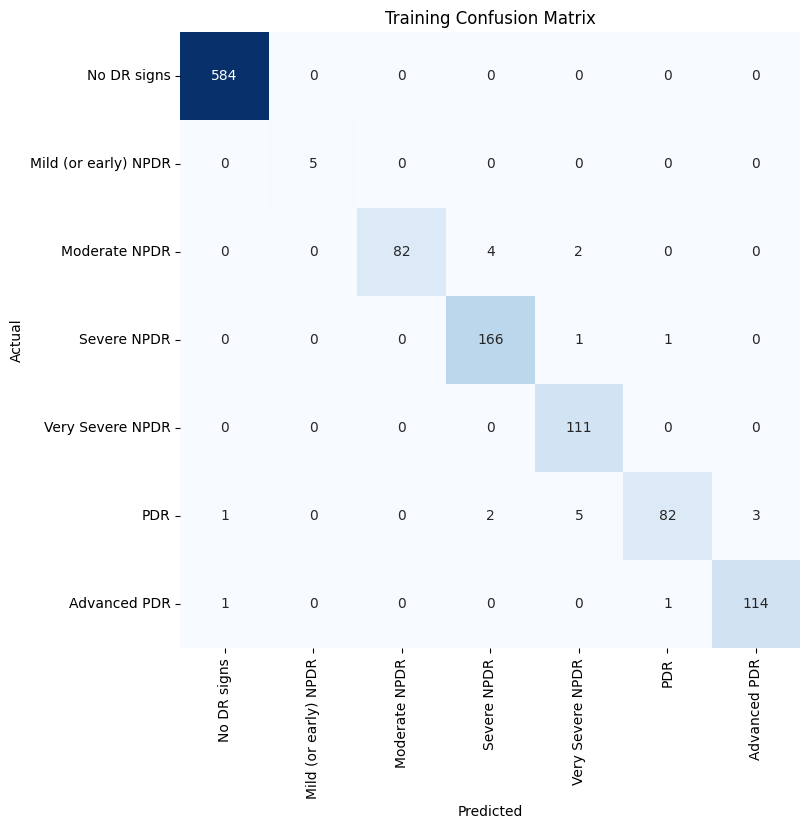

In [97]:
if len((diagnosis_classes.values()))<= 30:
        # create a confusion matrix
        cm = confusion_matrix(np.argmax(y_train,axis=1),y_pred_train)
        length=len(diagnosis_classes.values())
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, diagnosis_classes.values(), rotation= 90)
        plt.yticks(np.arange(length)+.5, diagnosis_classes.values(), rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Training Confusion Matrix")
        plt.show()

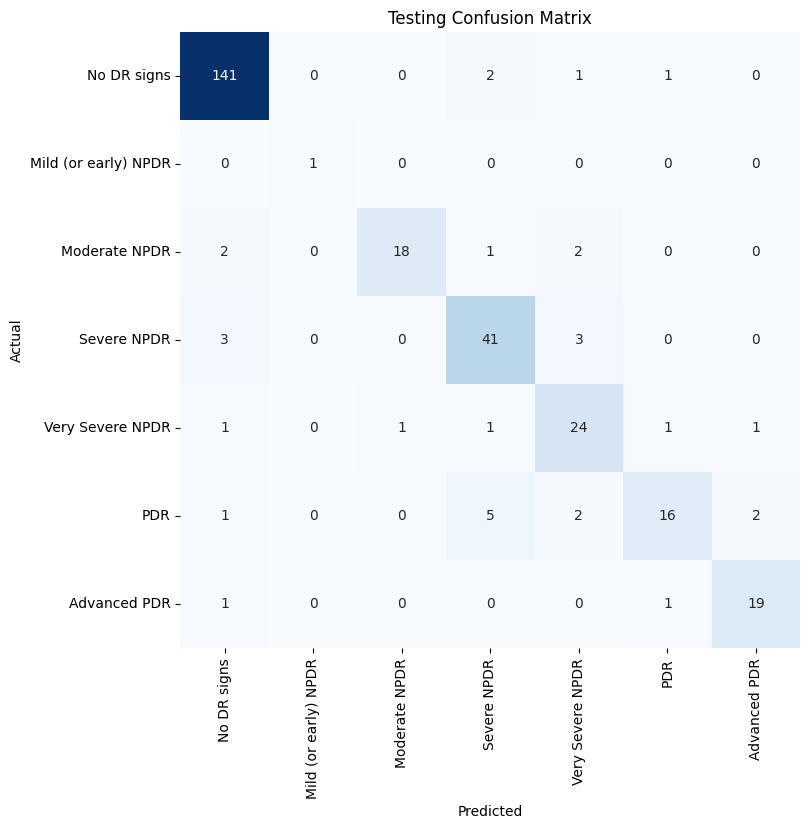

In [98]:
if len((diagnosis_classes.values()))<= 30:
      # create a confusion matrix
      cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred_val,labels=np.arange(0,len(diagnosis_classes),1))
      length=len(diagnosis_classes.values())
      if length<8:
          fig_width=8
          fig_height=8
      else:
          fig_width= int(length * .5)
          fig_height= int(length * .5)
      plt.figure(figsize=(fig_width, fig_height))
      sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
      plt.xticks(np.arange(length)+.5, diagnosis_classes.values(), rotation= 90)
      plt.yticks(np.arange(length)+.5, diagnosis_classes.values(), rotation=0)
      plt.xlabel("Predicted")
      plt.ylabel("Actual")
      plt.title("Testing Confusion Matrix")
      plt.show()

# PREDICTION FUNCTION

In [99]:
def predict_new(path):

    #predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"]
    img_list = []
    image = cv2.imread(path)
    image = cv2.resize(image, (400, 400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    copy = image.copy()
    copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(copy, (5, 5), 0)

    thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]

    # CONTOUR DETECTION
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = contour[0][0]
    contour = contour[:, 0, :]

    # GET COORDINATES
    x1 = tuple(contour[contour[:, 0].argmin()])[0]
    y1 = tuple(contour[contour[:, 1].argmin()])[1]
    x2 = tuple(contour[contour[:, 0].argmax()])[0]
    y2 = tuple(contour[contour[:, 1].argmax()])[1]

    #Crop Images Again to Destroy Black Area
    x = int(x2 - x1) * 4 // 50
    y = int(y2 - y1) * 5 // 50

    # THRES FOR CROPPED IMAGES
    copy2 = image.copy()
    if x2 - x1 > 100 and y2 - y1 > 100:
        copy2 = copy2[y1 + y: y2 - y, x1 + x: x2 - x]
        copy2 = cv2.resize(copy2, (240, 240))

    # LAB
    lab = cv2.cvtColor(copy2, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # CLAHE - Contrast-Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=((8, 8)))
    cl = clahe.apply(l)

    # MERGING LAB
    merge = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)
    med_blur = cv2.medianBlur(final_img, 3)
    back_gorund = cv2.medianBlur(final_img, 37)

    # MASK FOR BLEEDING VEIN
    mask = cv2.addWeighted(med_blur, 1, back_gorund, -1, 255)
    final = cv2.bitwise_and(mask, med_blur)
    img_list.append(final)
    ###############
    predict=model.predict(np.array(img_list))
    print(predict)
    pred=np.argmax(predict,axis=1)
    #pred=int(pred-1)
    print(pred)

    print(f"Predicted: {diagnosis_classes[int(pred)+1]}")

## Sample Predictions

In [100]:
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1002.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1003.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1004.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1005.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1006.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1007.jpg")

1/1 [==============================] - 0s 193ms/step
[[2.7582953e-02 1.7088492e-07 1.1381367e-02 7.5962245e-01 2.1766068e-01
  6.7569190e-03 7.7345534e-03]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 28ms/step
[[3.2822546e-04 1.9377574e-06 2.7485983e-03 7.3273760e-01 5.0027192e-01
  1.5383256e-02 9.4917722e-02]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 28ms/step
[[1.3662404e-02 4.5087013e-06 1.7585687e-02 6.7686802e-01 2.7785134e-01
  1.9877054e-02 6.1279267e-02]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 29ms/step
[[3.9180554e-02 3.6938457e-07 1.0787983e-01 8.8148677e-01 2.4095283e-01
  2.6072108e-03 2.5648830e-02]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 34ms/step
[[5.4933447e-03 4.5301212e-07 5.7691652e-02 9.2133886e-01 2.2311811e-01
  1.5593019e-03 3.8992077e-02]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 30ms/step
[[2.9581961e-01 1.3471908e-05 1.

In [101]:
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/718.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/719.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/720.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/721.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/722.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/723.jpg")

1/1 [==============================] - 0s 29ms/step
[[2.7786808e-03 8.5932035e-05 9.9131036e-01 4.0966440e-03 4.4281487e-03
  1.2116798e-05 7.2940812e-04]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 33ms/step
[[6.1825332e-03 7.2403791e-06 9.7934419e-01 2.2930466e-03 8.5576102e-03
  1.5488687e-05 1.6445087e-04]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 27ms/step
[[1.2086326e-03 9.9583610e-07 9.9275017e-01 2.5538123e-01 2.1399539e-03
  7.9055981e-06 1.1732393e-03]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 32ms/step
[[1.4194996e-03 1.1133494e-05 9.7109807e-01 3.9884109e-02 3.3803561e-03
  3.9260201e-05 8.3355969e-03]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 30ms/step
[[2.3273129e-03 6.9948865e-06 9.7905010e-01 2.1436516e-02 3.4894412e-03
  2.7478740e-05 4.1423468e-03]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 27ms/step
[[3.0050086e-04 1.24258

#RESENET152

In [102]:
from keras.applications import ResNet152
ResNet152 = ResNet152(include_top=False, input_shape= (240,240,3))

ResNet152.trainable=False

model = Sequential()
model.add(ResNet152)
model.add(Flatten())
model.add(Dense(128 , activation="relu"))
model.add(Dense(64 , activation="relu"))
model.add(Dense(32 , activation="relu"))
model.add(Dense(7 , activation="sigmoid"))

model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics="binary_accuracy" )
model.summary()

234698864/234698864 [==============================] - 2s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 8, 8, 2048)        58370944  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            0         
                                                                 
 dense_17 (Dense)            (None, 128)               16777344  
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 7)                 231       
                                                     

## Training

In [103]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(X_train , y_train , epochs=20 , batch_size=128,validation_data=(X_val,y_val), verbose=1 , callbacks = callbacks)

Epoch 1/20
10/10 [==============================] - 38s 2s/step - loss: 3.7284 - binary_accuracy: 0.7628 - val_loss: 1.0528 - val_binary_accuracy: 0.8571
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 0.7262 - binary_accuracy: 0.8697 - val_loss: 0.3990 - val_binary_accuracy: 0.8826
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 0.4020 - binary_accuracy: 0.8965 - val_loss: 0.3402 - val_binary_accuracy: 0.9163
Epoch 4/20
10/10 [==============================] - 13s 1s/step - loss: 0.2515 - binary_accuracy: 0.9280 - val_loss: 0.2376 - val_binary_accuracy: 0.9379
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 0.1387 - binary_accuracy: 0.9517 - val_loss: 0.1537 - val_binary_accuracy: 0.9437
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 0.0837 - binary_accuracy: 0.9677 - val_loss: 0.1258 - val_binary_accuracy: 0.9550
Epoch 7/20
10/10 [==============================] - 13s 1s/step - loss: 0.05

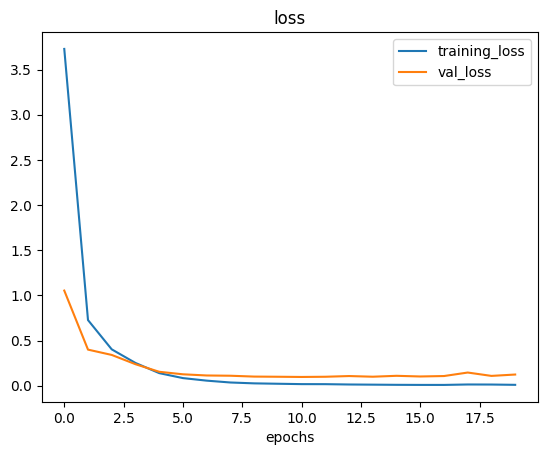

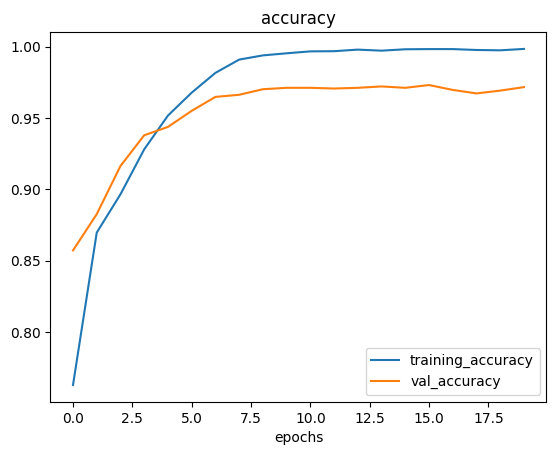

In [104]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

plot_curves(history)

In [105]:
pred = model.predict(X_val)
y_pred_val = np.argmax(pred,axis=1)
pred = np.argmax(pred,axis=1)

y_pred_train =model.predict(X_train)
y_pred_train =np.argmax(y_pred_train,axis=1)

37/37 [==============================] - 9s 249ms/step


In [106]:
df["status"].value_counts()

1    731
4    210
7    145
5    139
6    116
3    110
2      6
Name: status, dtype: int64

In [107]:
diagnosis_classes = {
    1: 'No DR signs',
    2: 'Mild (or early) NPDR',
    3: 'Moderate NPDR',
    4: 'Severe NPDR',
    5: 'Very Severe NPDR',
    6: 'PDR',
    7: 'Advanced PDR'
}



df["type"] = df["status"].map(diagnosis_classes.get)

## Metrics

In [108]:
train_metric = (accuracy_score(np.argmax(y_train,axis=1), y_pred_train))
val_metric = (accuracy_score(np.argmax(y_val,axis=1), y_pred_val))
print("Training accuracy:",train_metric,"Validation accuracy:",val_metric)

train_metric = (precision_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = (precision_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training precision:",train_metric,"Validation precision:",val_metric)

train_metric = (recall_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = (recall_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training Recall:",train_metric,"Validation Recall:",val_metric)

train_metric = (f1_score(np.argmax(y_train,axis=1), y_pred_train,average='macro'))
val_metric = (f1_score(np.argmax(y_val,axis=1), y_pred_val,average='macro'))
print("Training F1 score:",train_metric,"Validation F1-score:",val_metric)


print(classification_report(np.argmax(y_train,axis=1),y_pred_train,target_names=diagnosis_classes.values())) ## Training Classificaiton_report
print(classification_report(np.argmax(y_val,axis=1),y_pred_val,labels=np.arange(0,len(diagnosis_classes),1),target_names=diagnosis_classes.values()))## Validation Classificaiton_report

Training accuracy: 0.9939914163090129 Validation accuracy: 0.9006849315068494
Training precision: 0.9918372405141832 Validation precision: 0.9020189389681915
Training Recall: 0.991830271657934 Validation Recall: 0.8633310770380532
Training F1 score: 0.9917357541462714 Validation F1-score: 0.8700151901115213
                      precision    recall  f1-score   support

         No DR signs       1.00      1.00      1.00       584
Mild (or early) NPDR       1.00      1.00      1.00         5
       Moderate NPDR       1.00      1.00      1.00        88
         Severe NPDR       0.99      1.00      0.99       168
    Very Severe NPDR       0.99      1.00      1.00       111
                 PDR       0.99      0.95      0.97        93
        Advanced PDR       0.97      1.00      0.99       116

            accuracy                           0.99      1165
           macro avg       0.99      0.99      0.99      1165
        weighted avg       0.99      0.99      0.99      1165

      

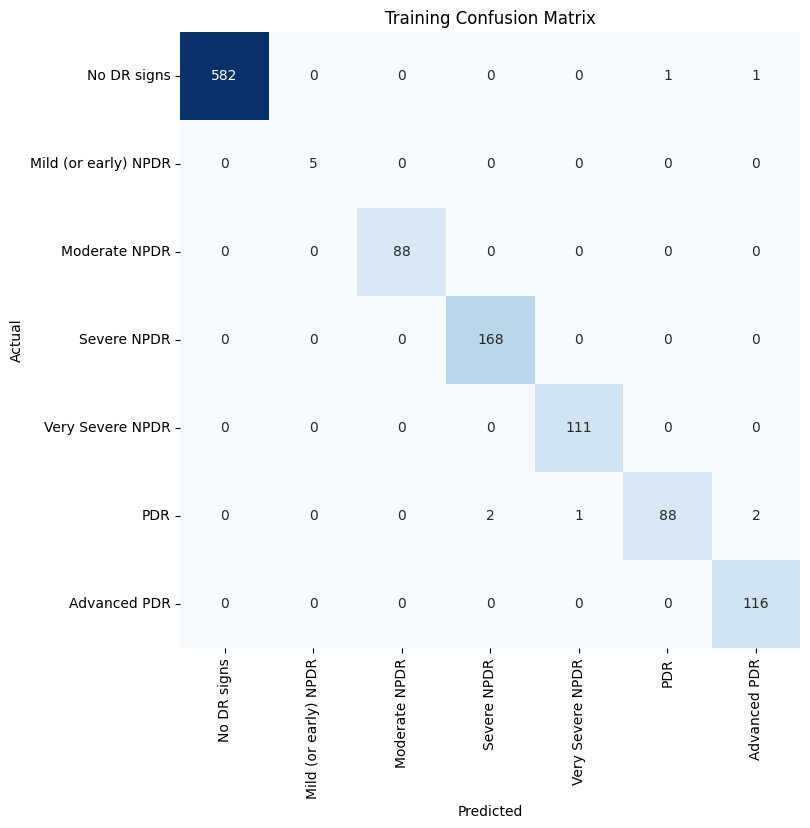

In [109]:
if len((diagnosis_classes.values()))<= 30:
        # create a confusion matrix
        cm = confusion_matrix(np.argmax(y_train,axis=1),y_pred_train)
        length=len(diagnosis_classes.values())
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, diagnosis_classes.values(), rotation= 90)
        plt.yticks(np.arange(length)+.5, diagnosis_classes.values(), rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Training Confusion Matrix")
        plt.show()

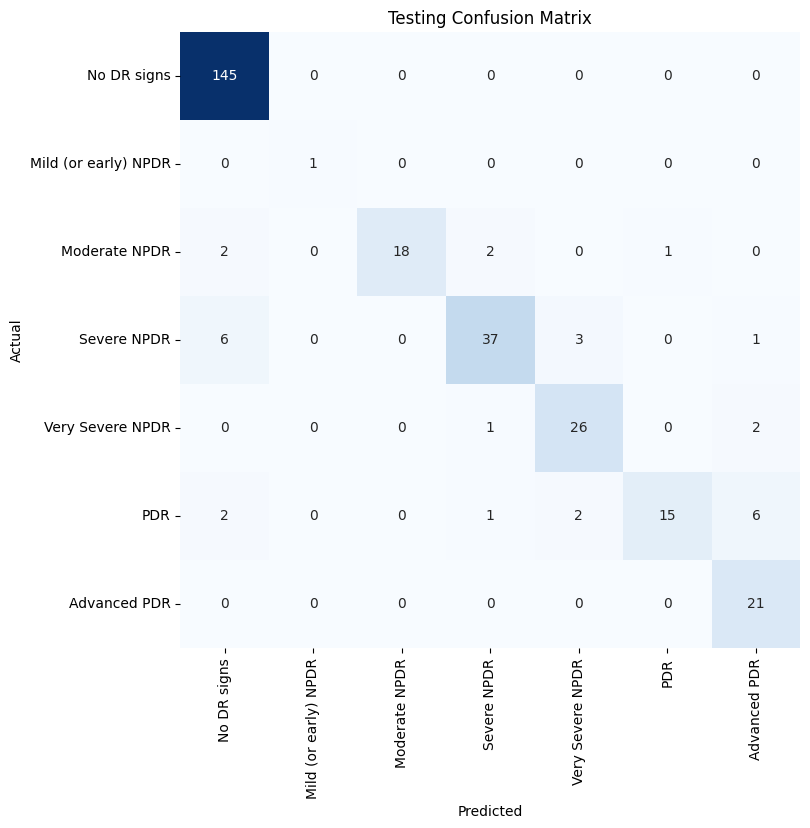

In [110]:
if len((diagnosis_classes.values()))<= 30:
      # create a confusion matrix
      cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred_val,labels=np.arange(0,len(diagnosis_classes),1))
      length=len(diagnosis_classes.values())
      if length<8:
          fig_width=8
          fig_height=8
      else:
          fig_width= int(length * .5)
          fig_height= int(length * .5)
      plt.figure(figsize=(fig_width, fig_height))
      sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
      plt.xticks(np.arange(length)+.5, diagnosis_classes.values(), rotation= 90)
      plt.yticks(np.arange(length)+.5, diagnosis_classes.values(), rotation=0)
      plt.xlabel("Predicted")
      plt.ylabel("Actual")
      plt.title("Testing Confusion Matrix")
      plt.show()

## Prediction Function

In [111]:
def predict_new(path):

    img_list = []
    image = cv2.imread(path)
    image = cv2.resize(image, (400, 400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    copy = image.copy()
    copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(copy, (5, 5), 0)

    thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]

    # CONTOUR DETECTION
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = contour[0][0]
    contour = contour[:, 0, :]

    # GET COORDINATES
    x1 = tuple(contour[contour[:, 0].argmin()])[0]
    y1 = tuple(contour[contour[:, 1].argmin()])[1]
    x2 = tuple(contour[contour[:, 0].argmax()])[0]
    y2 = tuple(contour[contour[:, 1].argmax()])[1]

    #Crop Images Again to Destroy Black Area
    x = int(x2 - x1) * 4 // 50
    y = int(y2 - y1) * 5 // 50

    # THRES FOR CROPPED IMAGES
    copy2 = image.copy()
    if x2 - x1 > 100 and y2 - y1 > 100:
        copy2 = copy2[y1 + y: y2 - y, x1 + x: x2 - x]
        copy2 = cv2.resize(copy2, (240, 240))

    # LAB
    lab = cv2.cvtColor(copy2, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # CLAHE - Contrast-Limited Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=((8, 8)))
    cl = clahe.apply(l)

    # MERGING LAB
    merge = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)
    med_blur = cv2.medianBlur(final_img, 3)
    back_gorund = cv2.medianBlur(final_img, 37)

    # MASK FOR BLEEDING VEIN
    mask = cv2.addWeighted(med_blur, 1, back_gorund, -1, 255)
    final = cv2.bitwise_and(mask, med_blur)
    img_list.append(final)
    ###############
    predict=model.predict(np.array(img_list))
    print(predict)
    pred=np.argmax(predict,axis=1)
    #pred=int(pred-1)
    print(pred)

    print(f"Predicted: {diagnosis_classes[int(pred)+1]}")

## Sample Predictions

In [114]:
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1002.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1003.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1004.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1005.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1006.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/4. Severe NPDR/1007.jpg")

1/1 [==============================] - 0s 67ms/step
[[2.5898011e-02 1.7049179e-07 2.6321234e-03 9.8272401e-01 2.6126439e-03
  1.2718741e-04 2.0289149e-06]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 49ms/step
[[5.11306629e-04 6.61698962e-08 1.00748835e-03 1.12273969e-01
  1.00143686e-01 6.14335537e-02 2.51700782e-04]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 48ms/step
[[2.8302274e-03 7.4411355e-10 7.8495094e-07 9.9950051e-01 1.6988552e-04
  2.6558433e-05 4.2053789e-04]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 47ms/step
[[9.44167899e-04 5.34008322e-08 3.31866630e-07 9.99272287e-01
  1.83356446e-04 2.54530081e-04 1.12817325e-02]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 67ms/step
[[1.0127964e-03 1.8911801e-06 1.3977049e-06 9.9875665e-01 4.1414471e-05
  1.2007681e-04 2.8017206e-02]]
[3]
Predicted: Severe NPDR
1/1 [==============================] - 0s 45ms/step
[[7.0424087e-04 1.3

In [113]:
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/718.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/719.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/720.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/721.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/722.jpg")
predict_new("/content/drive/MyDrive/diabetic retinopathy_V03/3. Moderate NPDR/723.jpg")

1/1 [==============================] - 0s 34ms/step
[[9.0811744e-05 6.3902122e-10 9.9755943e-01 3.9289366e-06 1.9331954e-02
  1.5869828e-05 2.2253560e-12]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 33ms/step
[[3.9542916e-05 1.4666157e-11 9.9484938e-01 5.3196063e-06 2.6948215e-02
  2.3461728e-06 6.9324156e-12]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 32ms/step
[[3.0547846e-05 6.1209544e-11 9.9880147e-01 1.0110502e-02 6.8750731e-03
  3.5811030e-05 2.0323349e-10]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 31ms/step
[[2.7565000e-06 2.9152344e-11 9.9793637e-01 3.6080563e-04 2.5247646e-02
  9.5212527e-06 2.8590054e-12]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 31ms/step
[[2.0575822e-06 1.1291960e-11 9.9951184e-01 5.3626409e-04 3.6080062e-02
  1.4659962e-05 5.3523392e-12]]
[2]
Predicted: Moderate NPDR
1/1 [==============================] - 0s 35ms/step
[[6.92001850e-05 1.5292